# Project :  Predicting Used Car Prices in Virginia using Machine Learning

### 1. Data Introduce
### 1.1 Purpose : Predict SalePrice
### 1.2 Data set:
- Collect Used Car data from Cars.com 
- Total Data : It consists of 14 variables and 1460 Used Car data

### 1.3 Evaluation
   > - Root-Mean-Squared-Error (RMSE)  

$$
RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}
$$



### 1. Exploring the Data
Let's start with importing the necessary libaries, reading in the data and checking out the dataset.

In [1]:
import pandas as pd
import numpy as np
import re
import pymysql, pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

def load_data():

    # Read Password

    pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
    host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 
    
    # AWS MySql Connection Info
    db = pymysql.connect(
        host = host_,
        user = "root",
        password = pw,
        db = "usedcar",
        charset='utf8',
    )

    SQL_QUERY = """
        SELECT *
        FROM usedcar;
    """

    train = pd.read_sql(SQL_QUERY, db)
    pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))
    
    return train

pw = pickle.load(open('./Flask/pickle/pw.pkl', 'rb'))
host_ = pickle.load(open('./Flask/pickle/host.pkl', 'rb')) 

# AWS MySql Connection Info
db = pymysql.connect(
    host = host_,
    user = "root",
    password = pw,
    db = "usedcar",
    charset='utf8',
)

SQL_QUERY = """
    SELECT *
    FROM usedcar;
"""

train = pd.read_sql(SQL_QUERY, db)
pickle.dump(train, open("./Flask/pickle/database.pkl", "wb"))

## 1. Load data

The stored data retrieved through data crawling is loaded into a DataFrame

In [400]:
train = pickle.load(open('./Flask/pickle/database.pkl', 'rb')) 

### (1) Check data

In [401]:
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 46924 rows and 16 columns


#### Comments :
There are 46924 instances of data and its number of attributes equals 16

### (2) Check data type

In [402]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46924 entries, 0 to 46923
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           46924 non-null  int64 
 1   ID              46924 non-null  object
 2   Year            46924 non-null  int64 
 3   Brand           46924 non-null  object
 4   Model           46924 non-null  object
 5   Mileage         46924 non-null  int64 
 6   Bodystyle       46545 non-null  object
 7   Dealer          45700 non-null  object
 8   Exterior Color  46924 non-null  object
 9   Interior Color  46923 non-null  object
 10  Drivetrain      46924 non-null  object
 11  MPG             46924 non-null  object
 12  Fuel Type       46924 non-null  object
 13  Transmission    46924 non-null  object
 14  Engine          46924 non-null  object
 15  Price           46924 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 5.7+ MB


#### Comments :

Out of a total of 16 columns, 4 are of type int64, while the remaining 12 are of type object. The total number of data entries is 46924, and it can be observed that Bodystyle, Dealer, and Interior Color have some missing values.

### (3) Status of Train data

In [403]:
train.describe()

,index,Year,Mileage,Price
count,46924.000000,46924.000000,46924.000000,4.692400e+04
mean,3205.419657,2016.172769,62118.963707,4.035456e+04
std,2293.697892,7.413188,50519.289211,7.761011e+04
min,0.000000,1937.000000,0.000000,2.432000e+03
25%,1248.000000,2014.000000,22556.000000,1.476800e+04
50%,2809.000000,2018.000000,50650.000000,2.500000e+04
75%,4835.000000,2021.000000,91468.000000,4.064900e+04
max,12424.000000,2024.000000,369197.000000,3.599000e+06


#### Comments :

There are no missing data in the numerical columns, and the oldest car was produced in 1937. The lowest price for a vehicle can be confirmed to be around $2,432.

## 2. Data Cleaning

### (1) Remove duplicate data using ID

The ID column is a combination of Year, Brand, Model, Mileage, and Dealer and was created to delete duplicate data. Now delete duplicate data using this column data

In [404]:
train = train.drop_duplicates(['ID']).reset_index(drop=True)
print(f'There are {train.shape[0]} rows and {train.shape[1]} columns') 

There are 4898 rows and 16 columns


#### Comments :

All duplicate data was deleted, leaving only 4898 out of 46924 data.
Since small data will affect performance when creating machine learning models later, I need to think about how to solve this problem.

### (2) Check the missing values

In [405]:
import missingno as msno 

<Axes: >

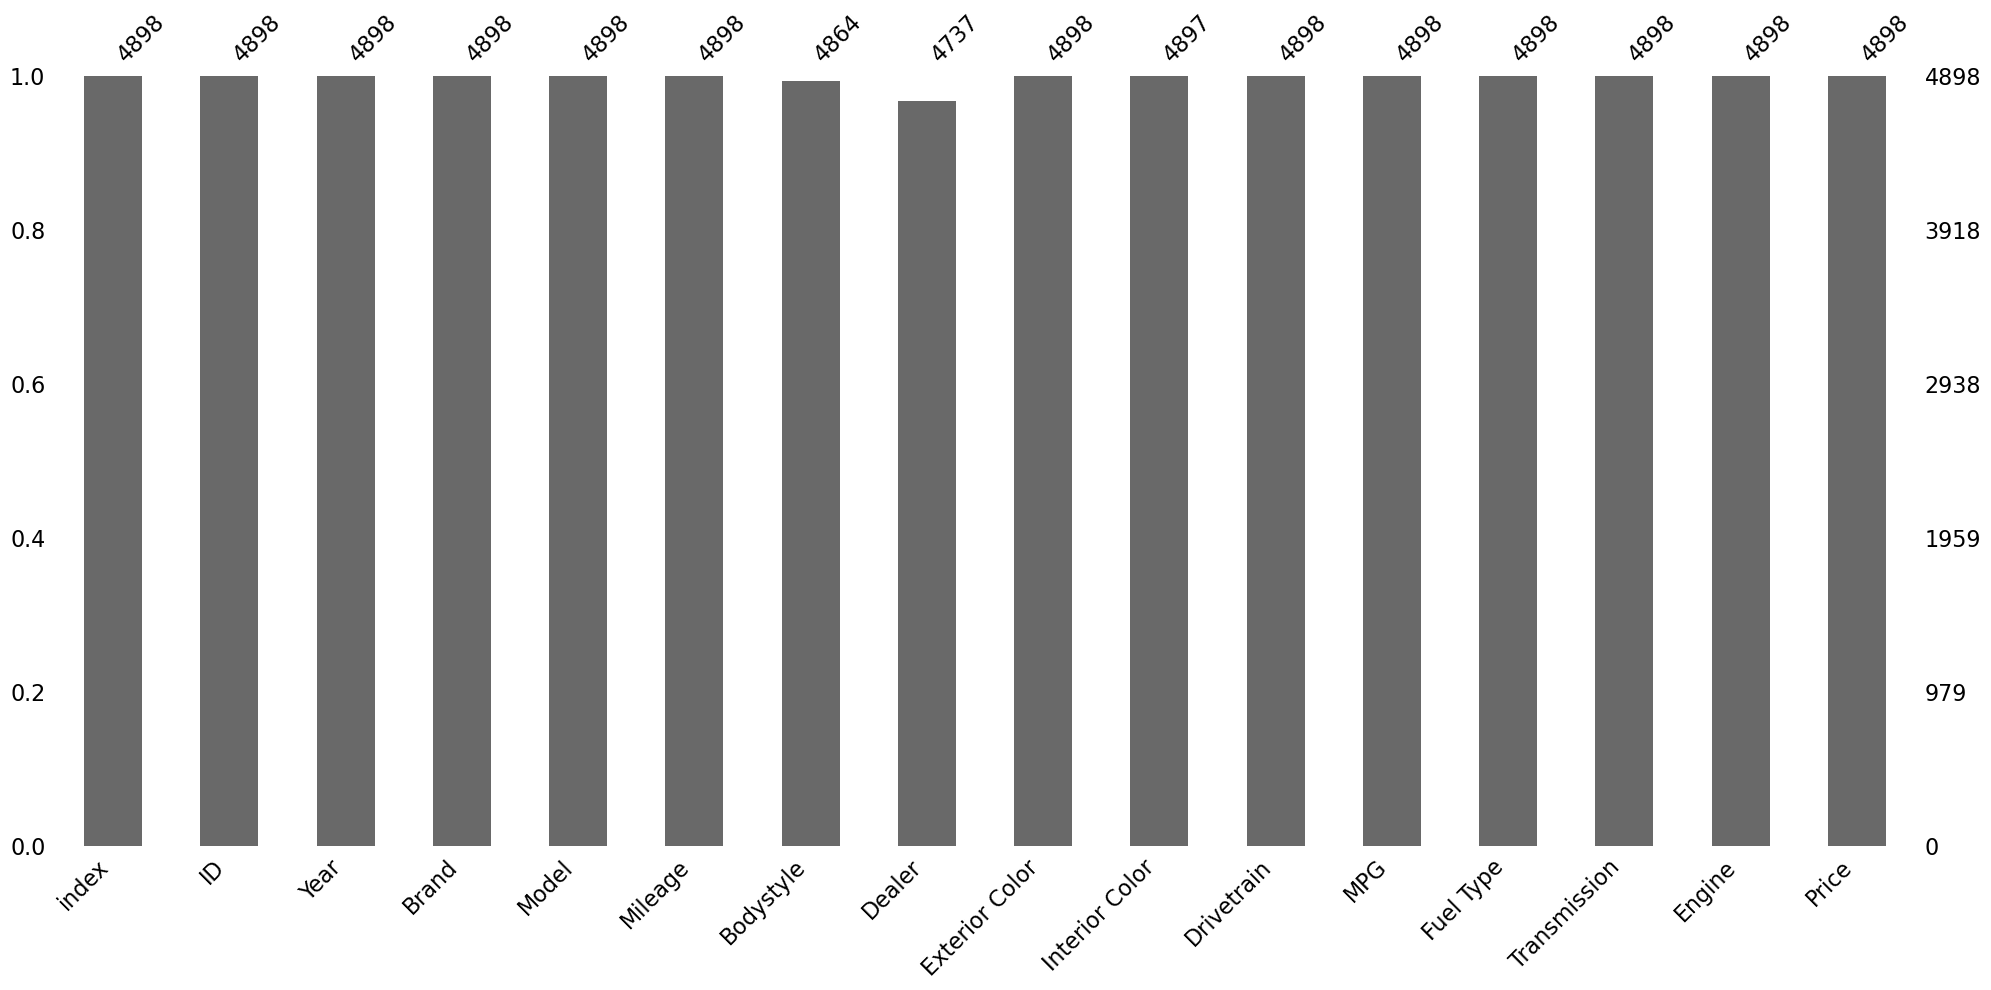

In [406]:
#Visualize missing values
msno.bar(train)

#### Comments :

It has been confirmed that there is missing data in Bodystyle and Dealer Interior Color, and it is necessary to add appropriate data in the future.

In [407]:
# Define a function to fill missing values with the most frequent value in each group
def fill_missing(group):
    mode_value = group.mode()
    if not mode_value.empty:
        return group.fillna(mode_value.iloc[0])
    else:
        return group

# Group by 'Model' column and apply the custom function to fill missing values in 'Bodystyle' column
train['Bodystyle'] = train.groupby('Model')['Bodystyle'].apply(fill_missing).reset_index(drop=True)

# Group by 'Model' column and apply the custom function to fill missing values in 'Interior Color' column
train['Interior Color'] = train.groupby('Model')['Interior Color'].apply(fill_missing).reset_index(drop=True)

# Find the most frequent dealer
most_frequent_dealer = train['Dealer'].mode()[0]

# Fill missing values in 'Dealer' column with the most frequent dealer value
train['Dealer'].fillna(most_frequent_dealer, inplace=True)


<Axes: >

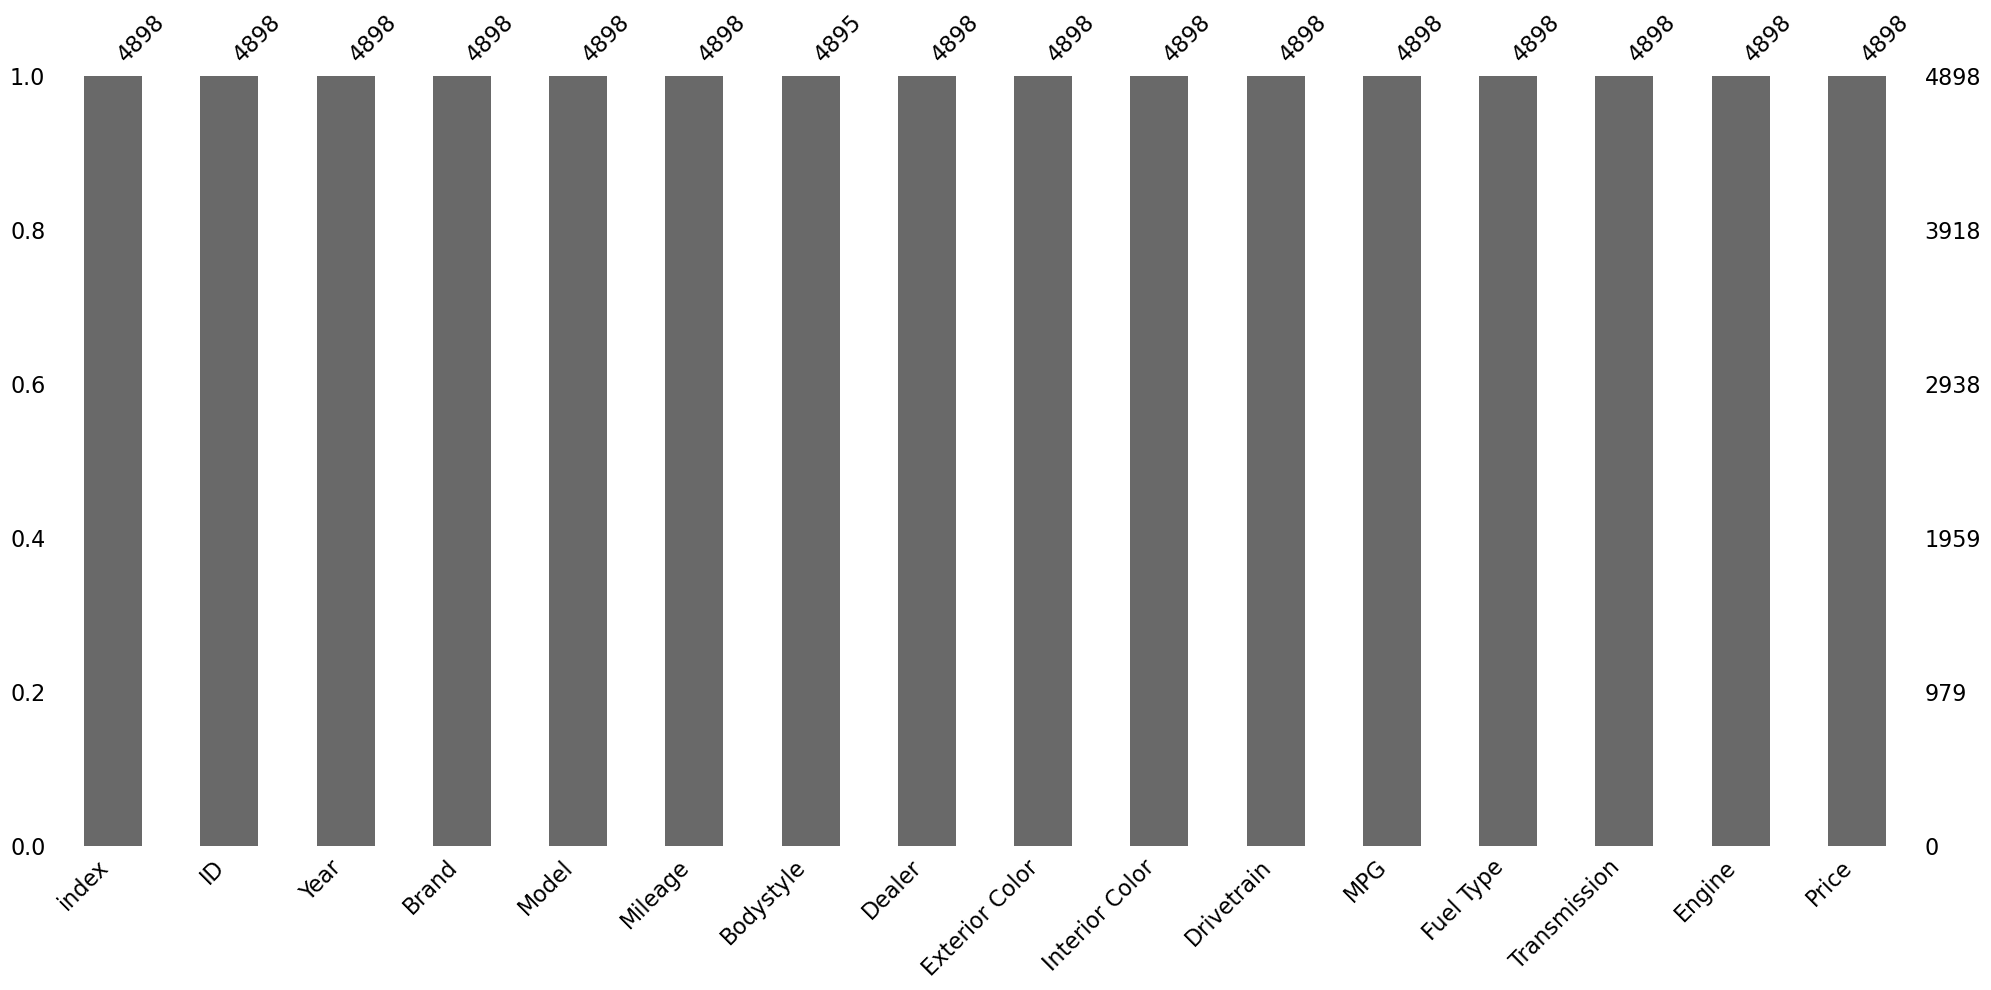

In [408]:
#Visualize missing values
msno.bar(train)

### (3) Delete unnecessary columns

Need to remove the unnecessary index column used along with the ID for deleting duplicate data during data analysis. The index was created when the data was stored in MySQL, and during the process of loading the data into the DataFrame, the index was created as a separate column in the DataFrame. This information is irrelevant to the data and needs to be removed.

In [409]:
train = train.drop(columns=['ID','index']).reset_index(drop=True)

### (4) Find and remove the outliers

The outliers could compromise the predictive power of the model. Using the quartile method, outliers in the prices of used cars were identified and removed.

In [410]:
import pandas as pd

# Identifying outliers
Q1 = train['Price'].quantile(0.25)
Q3 = train['Price'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

count_lower_bound = len(train[train['Price'] < lower_bound])
print("Lower Bound Price : ", lower_bound)
print("Number of cars priced below lower_bound :", count_lower_bound)
print("")


count_upper_bound = len(train[train['Price'] > upper_bound])
print("Upper Bound Price : ", upper_bound)
print("Number of cars priced above upper_bound :", count_upper_bound)
print("")

outliers = train[(train['Price'] < lower_bound) | (train['Price'] > upper_bound)]
outlier_prices = outliers['Price']
print("Number of outliers:", len(outlier_prices))


# Delete rows containing outliers.
train = train[~train['Price'].isin(outlier_prices)]

# Check the data after deletion.
print("Total number of rows after removing outliers:", len(train))

Lower Bound Price :  -20593.5
Number of cars priced below lower_bound : 0

Upper Bound Price :  76722.5
Number of cars priced above upper_bound : 419

Number of outliers: 419
Total number of rows after removing outliers: 4479


## 3. Exploratory Data Analysis (EDA)

### 3-1 An examination of price trend

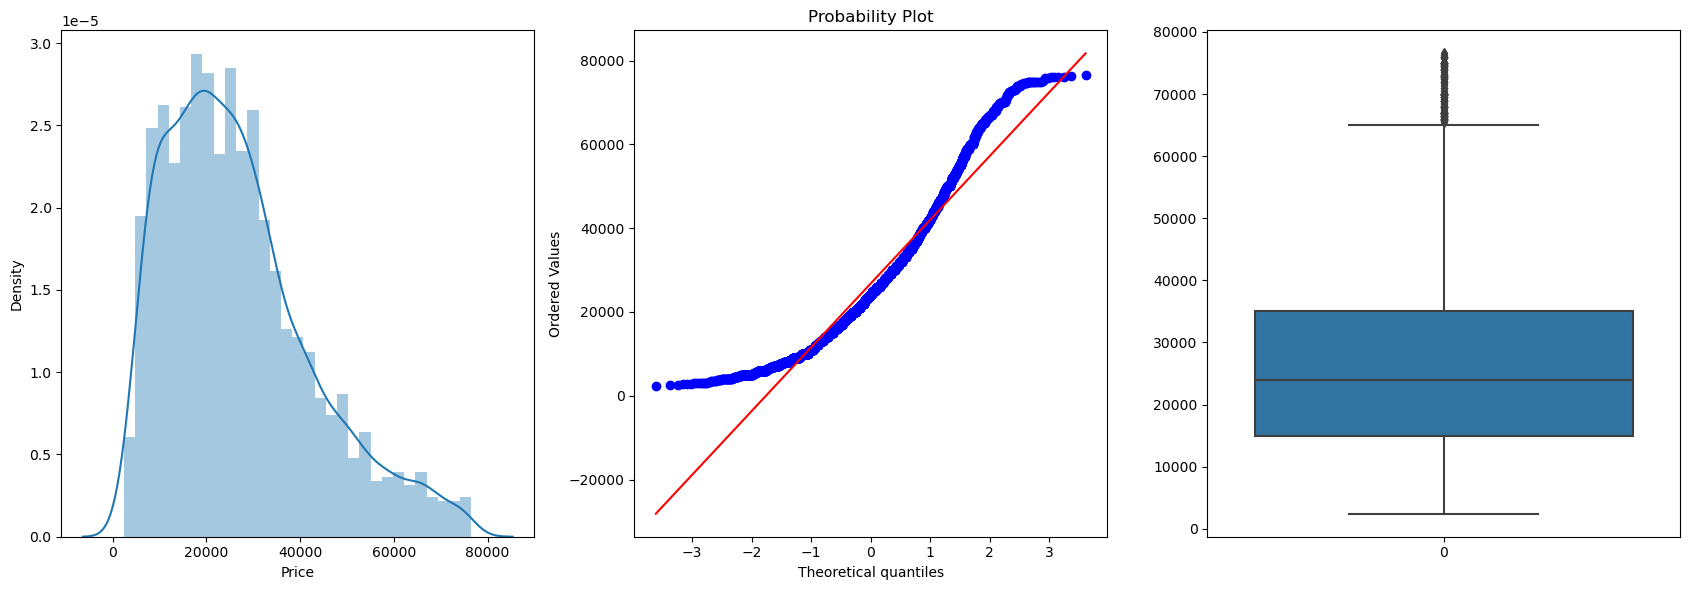

count     4479.000000
mean     26779.188212
std      15714.309215
min       2432.000000
25%      14950.000000
50%      23998.000000
75%      34995.000000
max      76557.000000
Name: Price, dtype: float64 

Skewness: 0.888484
Kurtosis: 0.377538


In [411]:
from scipy import stats
import seaborn as sns

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train["Price"])

plt.subplot(132)
stats.probplot(train["Price"], plot=plt)

plt.subplot(133)
sns.boxplot(train["Price"])
plt.tight_layout()
plt.show()

print(train["Price"].describe(),"\n")

print("Skewness: %f" % train['Price'].skew())
print("Kurtosis: %f" % train['Price'].kurt())

#### Comments :

It is apparent that used car price doesn't follow normal distribution and has positive skewness. The distribution of used car prices exhibits slight asymmetry, with a skewness of 0.88 and a kurtosis of 0.37. 

Most of the data is concentrated on the left side, forming a long tail on the right side. And its mean price is $26,779, with the lowest price being $2,432 and the highest price being $76,557

### Normalized price

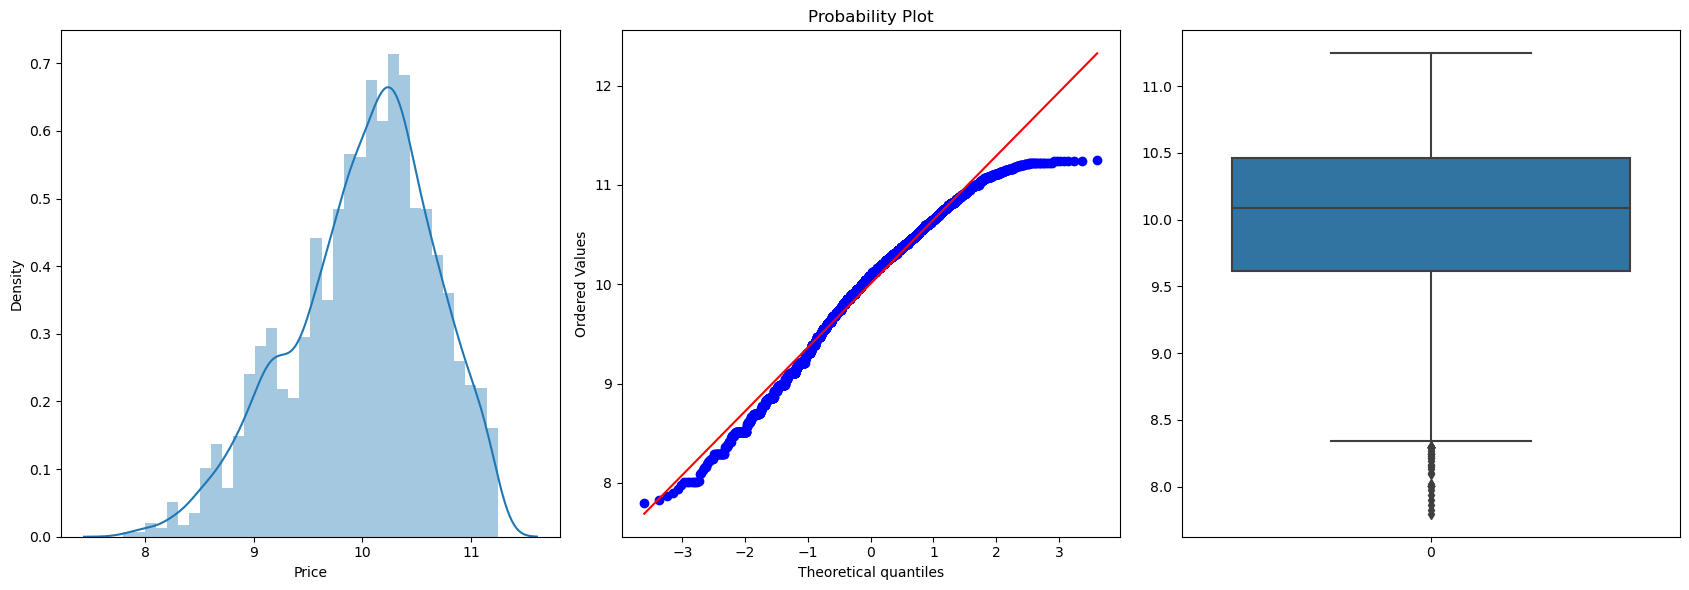

count    4479.000000
mean       10.007320
std         0.648500
min         7.796880
25%         9.612533
50%        10.085767
75%        10.462989
max        11.245804
Name: Price, dtype: float64 

Skewness: -0.484131
Kurtosis: -0.153538


In [412]:
nomalized_Price = np.log1p(train["Price"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(nomalized_Price)

plt.subplot(132)
stats.probplot(nomalized_Price, plot=plt)

plt.subplot(133)
sns.boxplot(nomalized_Price)
plt.tight_layout()
plt.show()

print(nomalized_Price.describe(),"\n")

print("Skewness: %f" % nomalized_Price.skew())
print("Kurtosis: %f" % nomalized_Price.kurt())

#### Comments :

Applying the logarithm transforms the used car prices into a more normalized distribution. The reason for using natural logarithm transformation is to alleviate the skewness effect in the data. By taking the logarithm of the used car prices, it compresses the scale of the data, mitigates the influence of extreme values, and makes the distribution more symmetrical. The used car prices transformed in this way are used later when building the model.

### 3-2 Relationship between features and price
### 3-2-1 Year and Price

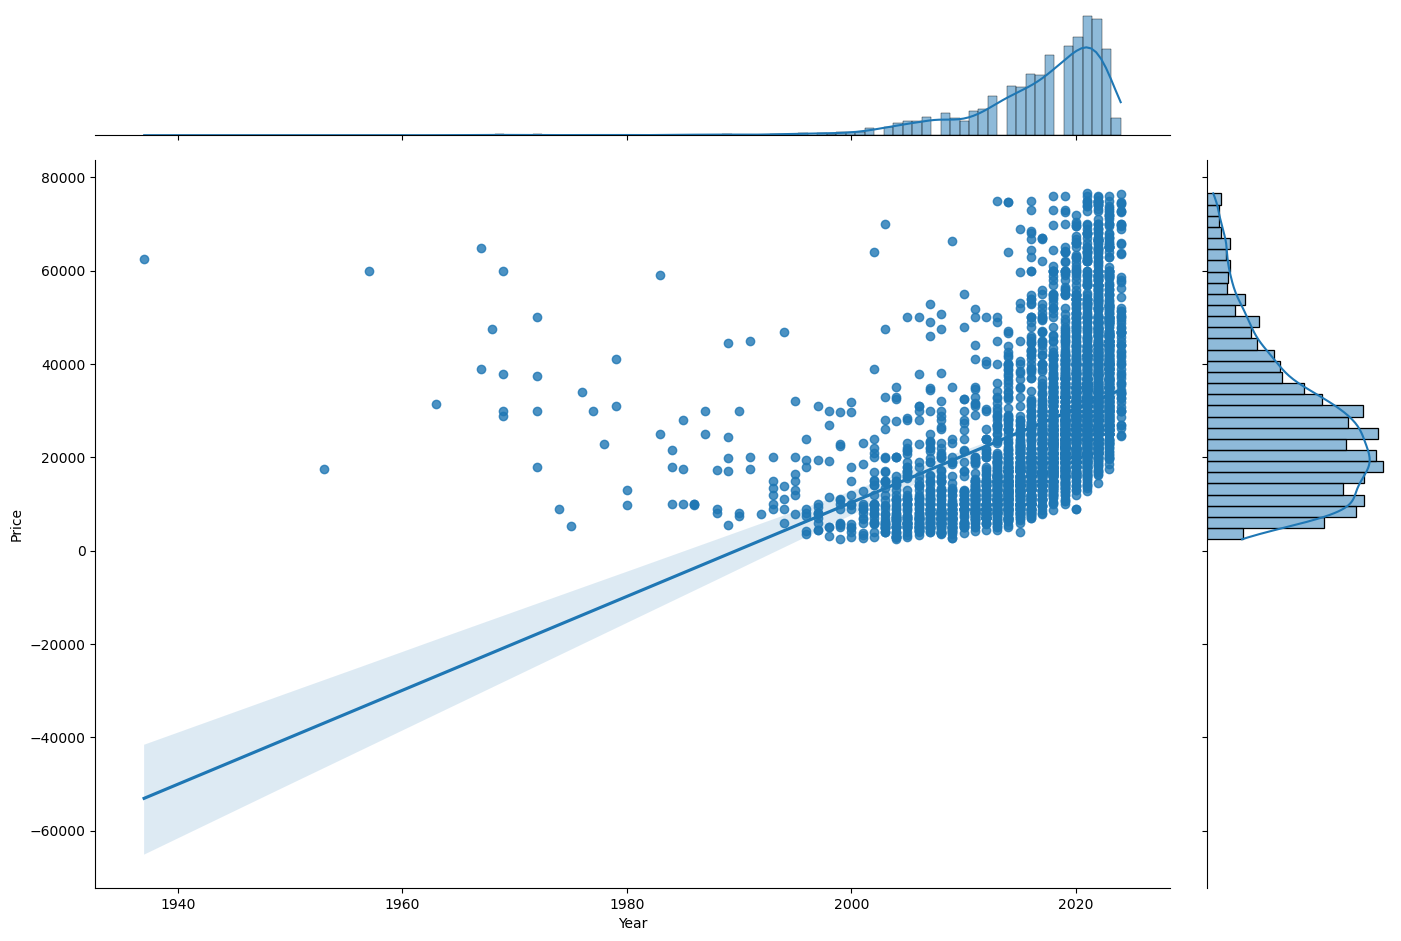

In [413]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Year", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

It shows a positive correlation. The more recent the year, the prices tend to be higher.

In [414]:
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]
sorted_filtered_data = filtered_data.sort_values(by='Year', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,1937,ford,coupe,12065,suv,exotic car trader,orange/red,black,rear-wheel,0–0,gasoline,automatic,350ci v8,62500
1,1957,porsche,356,5473,coupe,daniel schmitt & company,ivory,black,rear-wheel,0,gasoline,4-speed manual,1.9l flat-4,59900
2,1967,chevrolet,chevelle,61658,sedan,joe basil chevrolet,blue,tan,–,–,–,–,–,64957
3,1969,mercedes_benz,280se,103824,suv,mcginty motorcars,tan,ebony with ebony interior accents,rear-wheel,0–0,gasoline,3 speed automatic,i-6 cyl,59996
4,1983,jeep,cj,2609,convertible,gateway classic cars,black,matador red,–,0–0,–,th350 automatic,chevy 350 v8,59000


#### Comments :

After researching cars that maintain high prices despite their age, I found five vehicles. They were produced before the 1990s and cost more than 50,000. In particular, a 1937 Ford coupe topped the list with a price of 62,500 followed by the 1957 Porsche 356 model at 59,900

In [415]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Year'] <= 1989) & (train['Price'] >= 50000)]

### 3-2-2 Mileage and Price

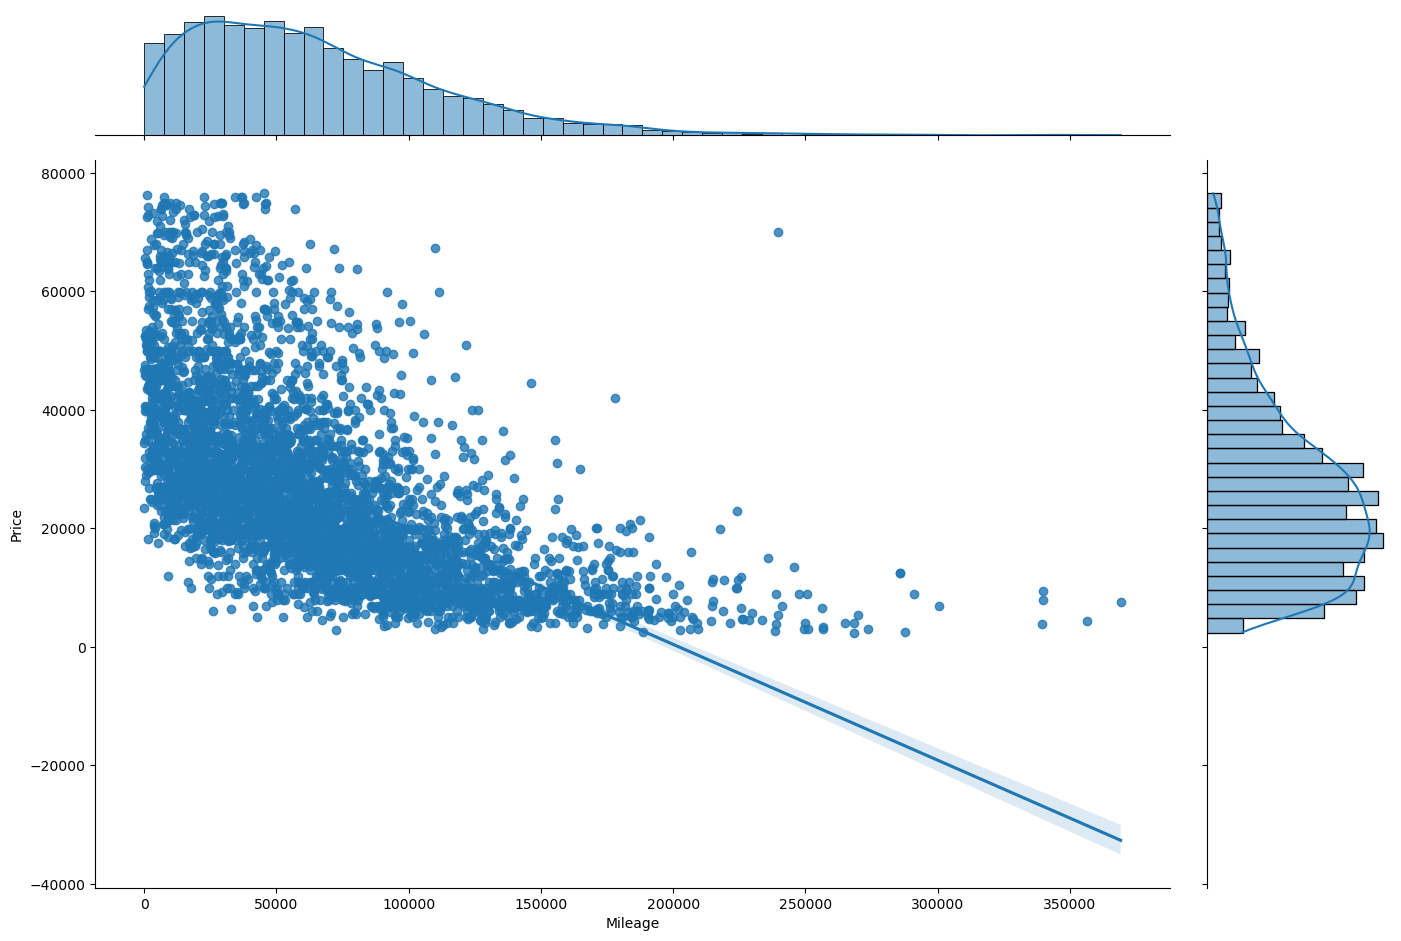

In [416]:
# Joint plot GrLivArea/saleprice
grid = sns.jointplot(x = "Mileage", y = "Price", data=train, kind="reg")
grid.fig.set_size_inches(15,10)

#### Comments :

Look into how used car prices vary depending on mileage. Found as expected Generally the lower the mileage the higher the price.

In [417]:
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]
sorted_filtered_data = filtered_data.sort_values(by='Mileage', ascending=True).reset_index(drop=True)
sorted_filtered_data

,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,2003,ford,excursion,239470,hatchback,east dallas diesel,other,black,four-wheel,–,diesel,5-speed automatic,6.0l v8 32v ddi ohv turbo diesel,69992


#### Comments :

There is a instance in the data where prices exceed 60,000 even with mileage exceeding 200,000. Upon reviewing the data, it was found that a Ford Excursion model from 2003, with mileage exceeding 230,000, had a price of 69,992. This data was removed from the train dataset as it could influence the prediction of used car prices

In [418]:
train = train.drop(filtered_data.index)
filtered_data = train[(train['Mileage'] > 200000) & (train['Price'] >= 60000)]

### 3-2-3 Brand & Model and Price

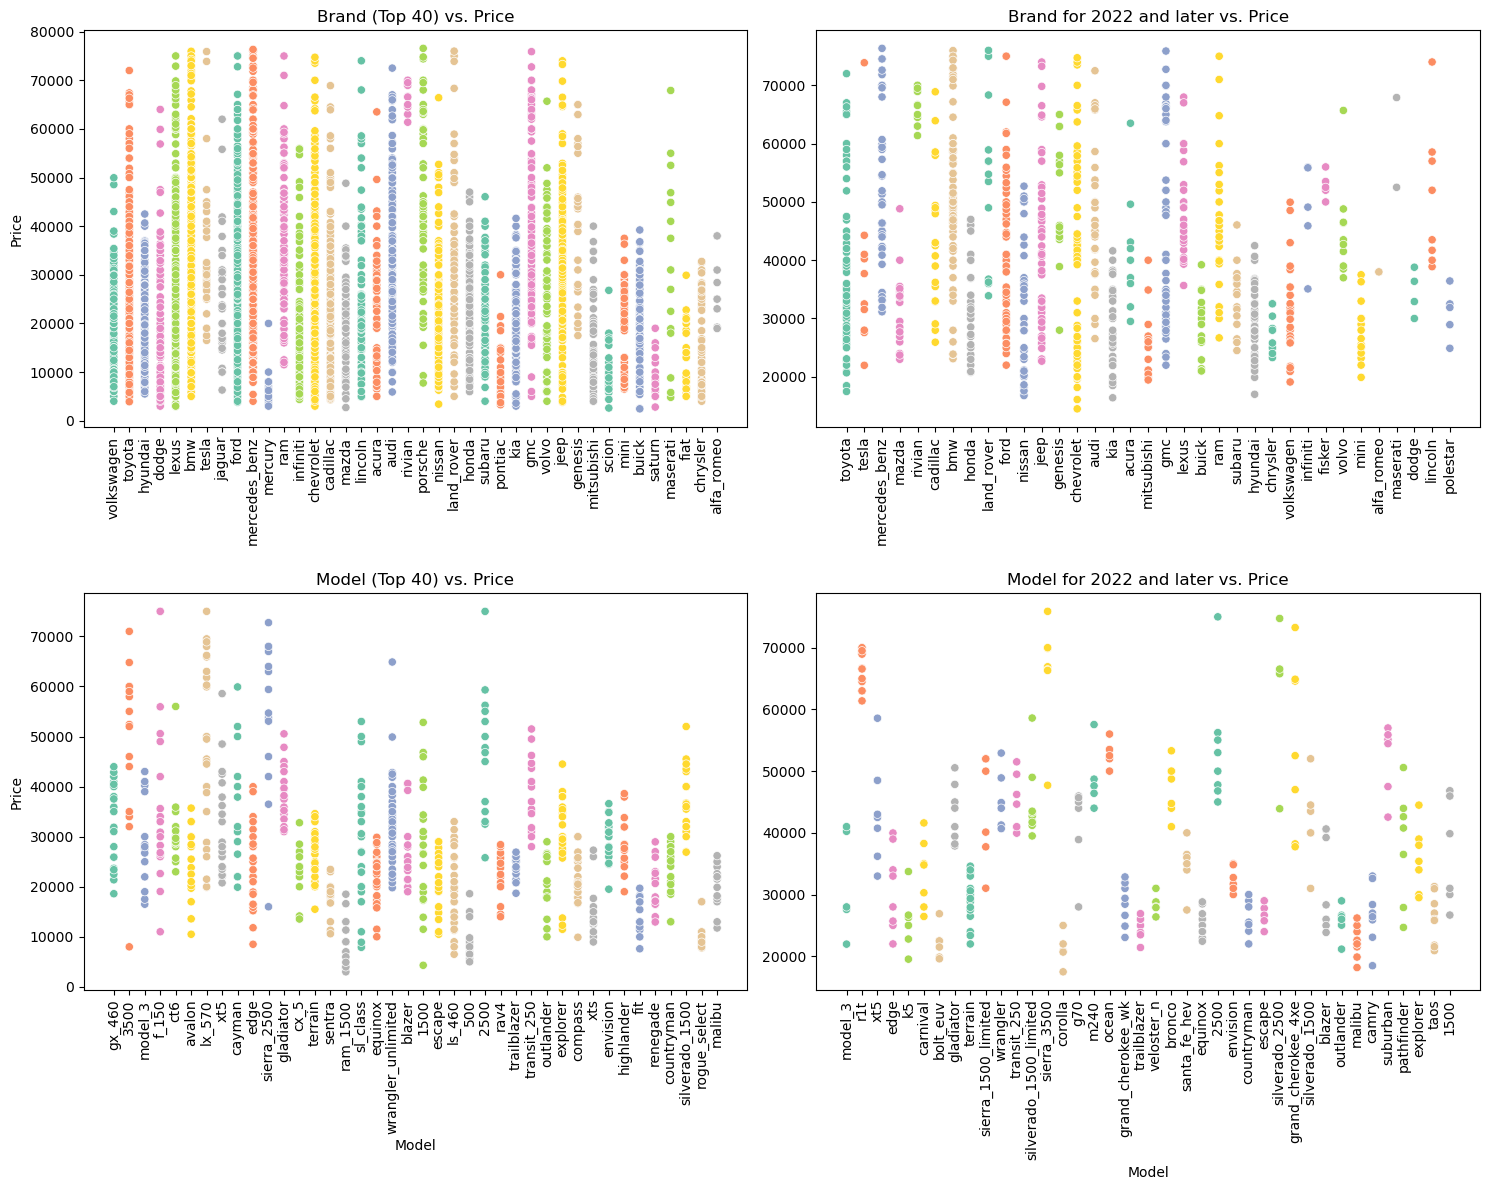

In [419]:
# Filter data for Year 2023 and later
train_2022 = train[train['Year'] >= 2022]

# Top 40 most frequent brands and models
top_brand = train['Brand'].value_counts().nlargest(40).index
top_model = train['Model'].value_counts().nlargest(40).index

# Top 40 most frequent brands and models for 2022 and later
top_brand_2022 = train_2022['Brand'].value_counts().nlargest(40).index
top_model_2022 = train_2022['Model'].value_counts().nlargest(40).index


# Extracting data corresponding to the top 40
top_brand_data = train[train['Brand'].isin(top_brand)]
top_model_data = train[train['Model'].isin(top_model)]

# Extract data corresponding to the top 40 brands and models for 2022 and later
top_brand_data_2022 = train_2022[train_2022['Brand'].isin(top_brand_2022)]
top_model_data_2022 = train_2022[train_2022['Model'].isin(top_model_2022)]


# Create a figure and axis objects
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Scatterplot for Brand
sns.scatterplot(ax=axes[0, 0], x='Brand', y='Price', hue='Brand', data=top_brand_data, palette='Set2')
axes[0, 0].legend().remove()
axes[0, 0].set_title('Brand (Top 40) vs. Price')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Price')
axes[0, 0].tick_params(axis='x', rotation=90)


# Scatterplot for Brand for 2022 and later
sns.scatterplot(ax=axes[0, 1], x='Brand', y='Price', hue='Brand', data=top_brand_data_2022, palette='Set2')
axes[0, 1].legend().remove()
axes[0, 1].set_title('Brand for 2022 and later vs. Price')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].tick_params(axis='x', rotation=90)


# Scatterplot for Model
sns.scatterplot(ax=axes[1, 0], x='Model', y='Price', hue='Model', data=top_model_data, palette='Set2')
axes[1, 0].legend().remove()
axes[1, 0].set_title('Model (Top 40) vs. Price')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Price')
axes[1, 0].tick_params(axis='x', rotation=90)


# Scatterplot for Model for 2022 and later
sns.scatterplot(ax=axes[1, 1], x='Model', y='Price', hue='Model', data=top_model_data_2022, palette='Set2')
axes[1, 1].legend().remove()
axes[1, 1].set_title('Model for 2022 and later vs. Price')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(h_pad=2)
plt.show()




#### Comments :

In the price distribution by brand, Volkswagen, Hyundai, and Tesla were observed to be concentrated within the 50000 range. Since older used cars tend to have lower prices, upon reevaluation using data from relatively newer cars produced after 2022, a similar distribution was observed. However, Toyota, Lexus, and Chevrolet had a broader distribution ranging from 10000 to 70000, and this distribution pattern remained consistent even for relatively newer cars produced after 2022. Regarding models, it was noted that prices were relatively concentrated within certain ranges for each model. Particularly, for cars produced after 2022, there was a more concentrated price distribution observed.

### 3-2-4 Exterior Color & Interior Color and Price

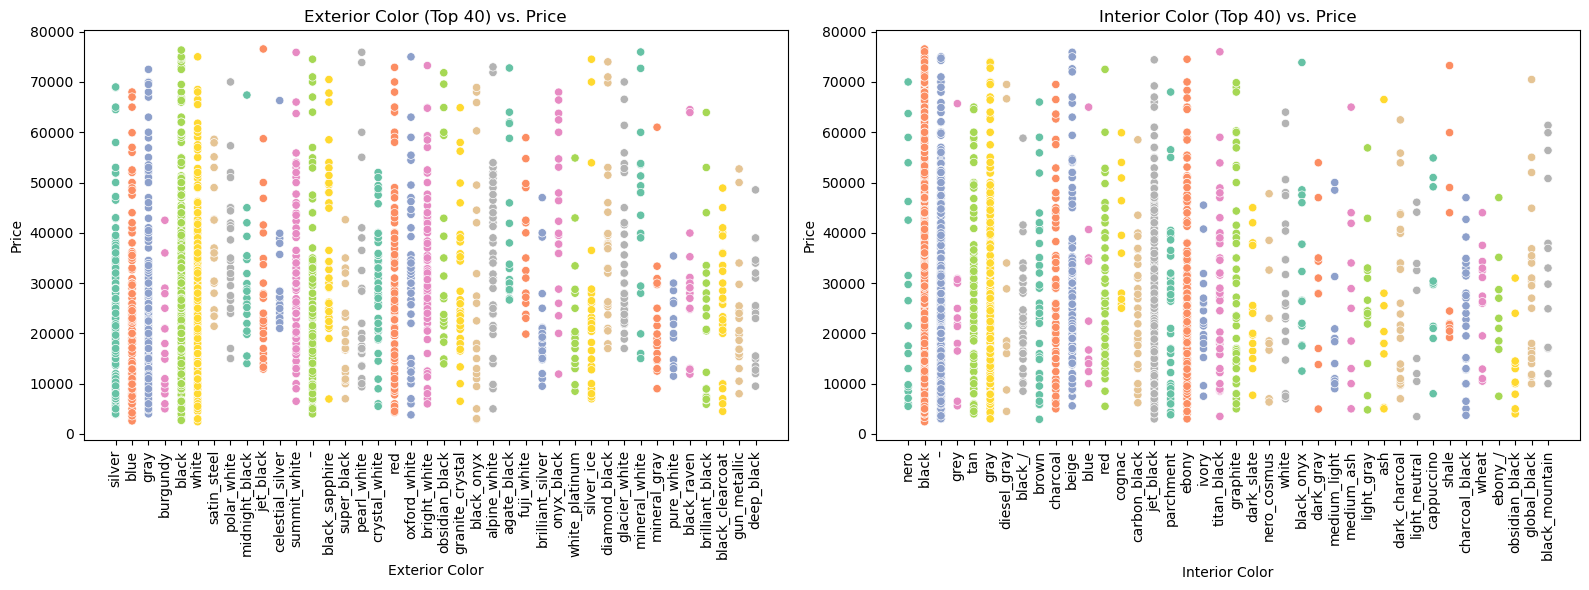

In [420]:
# Exterior Color and Interior Color preprocessing
train['Exterior Color'] = train['Exterior Color'].apply(lambda x: '_'.join(x.split()[:2]))
train['Interior Color'] = train['Interior Color'].apply(lambda x: '_'.join(x.split()[:2]) if isinstance(x, str) else x)

# top 40 most frequent  Colors
top_exterior_colors = train['Exterior Color'].value_counts().nlargest(40).index
top_interior_colors = train['Interior Color'].value_counts().nlargest(40).index

# Extracting data corresponding to the top 40
top_exterior_colors_data = train[train['Exterior Color'].isin(top_exterior_colors)]
top_interior_colors_data = train[train['Interior Color'].isin(top_interior_colors)]

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Scatterplot for Exterior Color
sns.scatterplot(ax=axes[0], x='Exterior Color', y='Price', hue='Exterior Color', data=top_exterior_colors_data, palette='Set2')
axes[0].legend().remove()
axes[0].set_title('Exterior Color (Top 40) vs. Price')
axes[0].set_xlabel('Exterior Color')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=90)

# Scatterplot for Interior Color
sns.scatterplot(ax=axes[1], x='Interior Color', y='Price', hue='Interior Color', data=top_interior_colors_data, palette='Set2')
axes[1].legend().remove()
axes[1].set_title('Interior Color (Top 40) vs. Price')
axes[1].set_xlabel('Interior Color')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### Comments :

there is no correlation between exterior color and price, as well as between interior color and price.

### 3-2-5 Drivetrain and Price

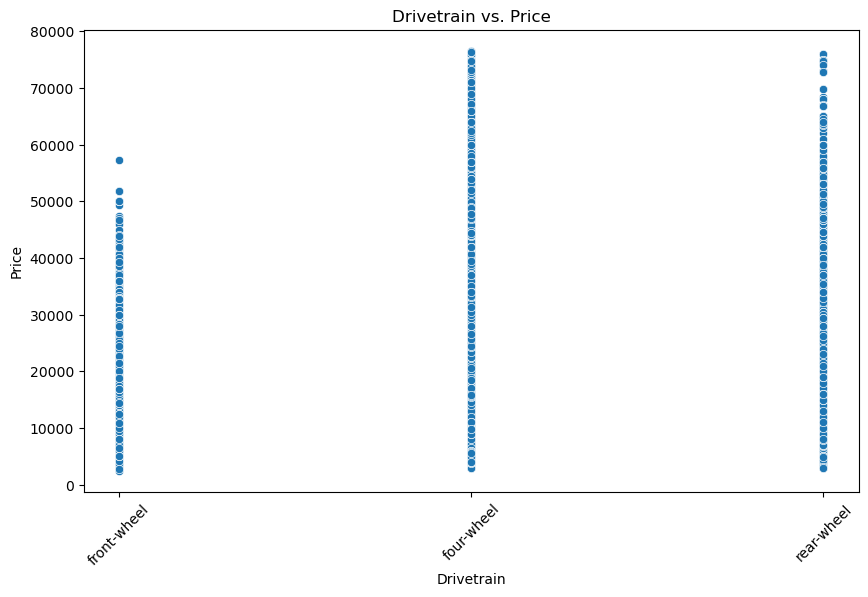

In [421]:
# Preprocessing
train['Drivetrain'] = train['Drivetrain'].replace({'fwd': 'front-wheel', 'rwd': 'rear-wheel', '4wd': 'four-wheel', 'all-wheel': 'four-wheel', 'awd': 'four-wheel','unknown': 'front-wheel','–': 'front-wheel'})

plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='Drivetrain', y='Price', data=train)
plt.title('Drivetrain vs. Price')
plt.xlabel('Drivetrain')
plt.ylabel('Price')
plt.xticks(rotation=45) 
plt.show()

#### Comments :

There is no correlation between Drivetrain and price

### 3-2-6 MPG, Fuel Type, Transmission Engine and Price

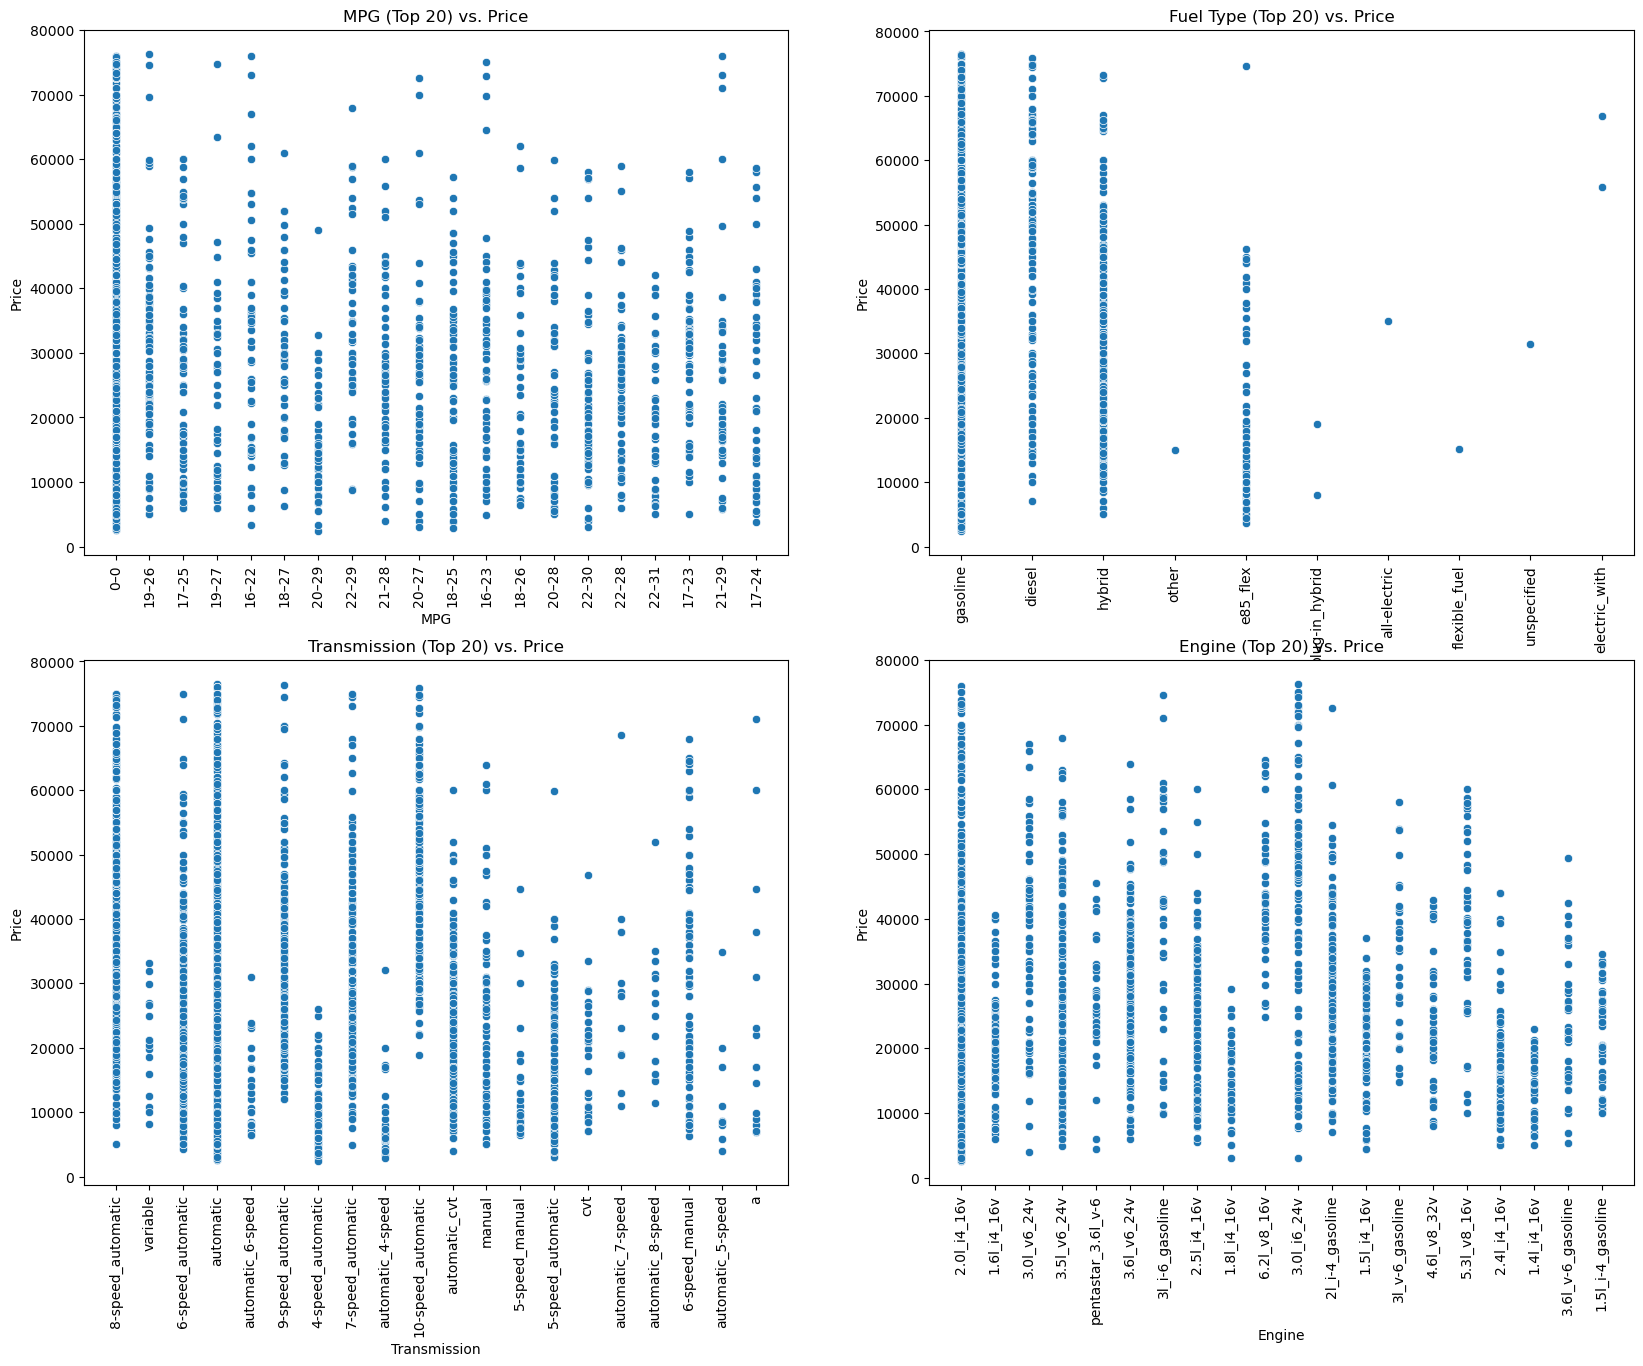

In [422]:
# Process the values of the 'MPG', 'Fuel Type', 'Transmission', 'Engine' columns and save them back to the train data
train['MPG'] = train['MPG'].apply(lambda x: '_'.join(x.split()[:2]))
train['Fuel Type'] = train['Fuel Type'].apply(lambda x: '_'.join(x.split()[:2]))
train['Transmission'] = train['Transmission'].apply(lambda x: '_'.join(x.split()[:2]))
train['Engine'] = train['Engine'].apply(lambda x: '_'.join(x.split()[:3]))

# Replace missing values or '-' with the most frequently used value in each column
train['MPG'].replace('', np.nan, inplace=True)
train['MPG'].replace('–', np.nan, inplace=True)
train['Fuel Type'].replace('', np.nan, inplace=True)
train['Fuel Type'].replace('–', np.nan, inplace=True)
train['Transmission'].replace('', np.nan, inplace=True)
train['Transmission'].replace('–', np.nan, inplace=True)
train['Engine'].replace('', np.nan, inplace=True)
train['Engine'].replace('–', np.nan, inplace=True)

train['MPG'].fillna(train['MPG'].mode()[0], inplace=True)
train['Fuel Type'].fillna(train['Fuel Type'].mode()[0], inplace=True)
train['Transmission'].fillna(train['Transmission'].mode()[0], inplace=True)
train['Engine'].fillna(train['Engine'].mode()[0], inplace=True)

# Extract the top 30 data for each column
top_mpg = train['MPG'].value_counts().nlargest(20).index
top_fuel_type = train['Fuel Type'].value_counts().nlargest(20).index
top_transmission = train['Transmission'].value_counts().nlargest(20).index
top_engine = train['Engine'].value_counts().nlargest(20).index

# Draw 4 scatterplot graphs
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
sns.scatterplot(x='MPG', y='Price', data=train[train['MPG'].isin(top_mpg)])
plt.title('MPG (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.scatterplot(x='Fuel Type', y='Price', data=train[train['Fuel Type'].isin(top_fuel_type)])
plt.title('Fuel Type (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.scatterplot(x='Transmission', y='Price', data=train[train['Transmission'].isin(top_transmission)])
plt.title('Transmission (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.scatterplot(x='Engine', y='Price', data=train[train['Engine'].isin(top_engine)])
plt.title('Engine (Top 20) vs. Price')
plt.xticks(rotation=90)

plt.show()


#### Comments :

The relationship between the remaining columns, MPG, Fuel Type, Transmission, Engine, and Price indicates that most values were widely distributed regardless of price. However, in the case of Transmission, it could be observed that price ranges are partially formed according to the type of Transmission. Values such as variable, automatic_6 speed, and 4-speed automatic were gathered in lower price ranges below $35,000

## 4. Feature Selection

In [423]:
from sklearn.preprocessing import LabelEncoder

numerical_features_all = []
categorical_features_all = []

# Differentiating between numerical and categorical variables after checking the data type of each column
for f in train_all.columns:
    if train_all.dtypes[f] != 'object':
        numerical_features_all.append(f)
    else:
        categorical_features_all.append(f)

# Creating a LabelEncoder object
label_encoder = LabelEncoder()

# Applying LabelEncoder to categorical variables and creating dummy variables
for feature in categorical_features_all:
    train_all[feature] = label_encoder.fit_transform(train_all[feature])

# Creating dummy variables
normalize_num_all = np.log1p(train_all[numerical_features_all])
X_train_0_all = normalize_num_all.join(train_all[categorical_features_all])

y_train_all = X_train_0_all["Price"]
X_train_all = X_train_0_all.drop("Price", axis=1)


,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,7.611842,3.951244,6.670766,10.070145,2.484907,6.403574,6.426488,3.761200,0.693147,5.147494,1.791759,3.713572,4.262680,10.085767
1,7.612831,3.931826,6.406880,7.988882,1.609438,6.712956,6.597146,5.627621,0.693147,5.894403,1.791759,4.584967,5.117994,10.410847
2,7.609862,2.995732,4.477337,11.489411,2.397895,7.027315,5.231109,3.583519,0.693147,5.398163,1.791759,3.091042,3.555348,9.158837
3,7.609367,2.484907,5.533389,11.586845,2.397895,6.499787,4.672829,5.438079,0.693147,5.332719,1.791759,3.091042,4.262680,8.845345
4,7.611842,3.332205,6.028279,11.025475,2.484907,7.530480,6.333280,3.761200,0.000000,3.784190,1.791759,4.043051,5.783825,10.545341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4468,7.612831,2.833213,6.666957,9.916799,2.484907,4.077537,5.683580,5.549076,0.000000,5.220356,1.791759,3.806662,3.295837,10.237528
4469,7.611842,1.945910,6.206576,10.563724,2.397895,6.825460,6.251904,5.793014,0.000000,5.164786,1.791759,3.713572,4.262680,10.415203
4470,7.609862,3.433987,6.324359,11.239173,1.098612,7.845416,6.665684,0.693147,1.098612,5.393628,1.791759,4.465908,6.345636,9.851984
4471,7.608871,2.079442,6.150603,11.808591,2.397895,7.483807,5.288267,5.631212,0.693147,4.595120,1.098612,3.091042,5.472271,9.433324


numerical_features_all = []
categorical_features_all = []
for f in train_all.columns:
    if train_all.dtypes[f] != 'object':
        numerical_features_all.append(f)
    else:
        categorical_features_all.append(f)
        
dummy_cat_all = pd.get_dummies(train_all[categorical_features_all], dtype=int, drop_first=True)
normalize_num_all = np.log1p(train_all[numerical_features_all])
X_train_0_all= normalize_num_all.join(dummy_cat_all)

y_train_all = X_train_0_all["Price"]
X_train_all = X_train_0_all.drop("Price", axis=1)

In [289]:
# Divide into numeric and categorical variables
numerical_features_reduced = []
categorical_features_reduced = []
for f in train_reduced.columns:
    if train_reduced.dtypes[f] != 'object':
        numerical_features_reduced.append(f)
    else:
        categorical_features_reduced.append(f)
        
numerical_features_all = []
categorical_features_all = []
for f in train_all.columns:
    if train_all.dtypes[f] != 'object':
        numerical_features_all.append(f)
    else:
        categorical_features_all.append(f)
        
        
# Dummy category variable
dummy_cat_reduced = pd.get_dummies(train_reduced[categorical_features_reduced])
normalize_num_reduced = np.log1p(train_reduced[numerical_features_reduced])

dummy_cat_all = pd.get_dummies(train_all[categorical_features_all])
normalize_num_all = np.log1p(train_all[numerical_features_all])

# Join numeric variable with categoric variable
X_train_0_reduced = normalize_num_reduced.join(dummy_cat_reduced)
X_train_0_all= normalize_num_all.join(dummy_cat_all)

# Seperate price as y value
y_train_reduced = X_train_0_reduced["Price"]
X_train_reduced = X_train_0_reduced.drop("Price", axis=1)

y_train_all = X_train_0_all["Price"]
X_train_all = X_train_0_all.drop("Price", axis=1)

In [290]:
train_reduced

,Year,Brand,Model,Mileage,Price
0,2021,volkswagen,tiguan,23626,23998
1,2023,toyota,prius,2947,33217
2,2017,hyundai,accent,97675,9497
3,2016,dodge,dart,107671,6941
4,2021,lexus,gx_460,61418,37999
...,...,...,...,...,...
4468,2023,gmc,terrain,20267,27931
4469,2021,bmw,m235_gran_coupe,38704,33362
4470,2017,mazda,mx_5_miata,76051,18995
4471,2015,buick,lacrosse,134401,12497


In [296]:
for i in X_train_0_all.columns:
    if i != 'Price':
        print(i)

Year
Mileage
Brand_acura
Brand_alfa romeo
Brand_alfa_romeo
Brand_aston_martin
Brand_audi
Brand_bentley
Brand_bmw
Brand_buick
Brand_cadillac
Brand_chevrolet
Brand_chrysler
Brand_dodge
Brand_fiat
Brand_fisker
Brand_ford
Brand_genesis
Brand_gmc
Brand_honda
Brand_hummer
Brand_hyundai
Brand_infiniti
Brand_isuzu
Brand_jaguar
Brand_jeep
Brand_karma
Brand_kia
Brand_land_rover
Brand_lexus
Brand_lincoln
Brand_maserati
Brand_mazda
Brand_mercedes_benz
Brand_mercury
Brand_mini
Brand_mitsubishi
Brand_nissan
Brand_oldsmobile
Brand_plymouth
Brand_polestar
Brand_pontiac
Brand_porsche
Brand_ram
Brand_rivian
Brand_saab
Brand_saturn
Brand_scion
Brand_smart
Brand_subaru
Brand_suzuki
Brand_tesla
Brand_toyota
Brand_volkswagen
Brand_volvo
Model_124_spider
Model_128
Model_135
Model_1500
Model_1500_classic
Model_2
Model_200
Model_228
Model_228 gran coupe
Model_228_gran_coupe
Model_230
Model_2500
Model_300
Model_3000gt
Model_300c
Model_300zx
Model_318
Model_320
Model_323
Model_325
Model_328
Model_328_gran_turism

In [276]:
all_ = X_train_all
all_y = y_train_all
reduced_ = X_train_reduced
reduced_y = y_train_reduced

In [277]:
# Initialize K-ford
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train_reduced = np.array(X_train_reduced)
y_train_reduced = np.array(y_train_reduced)

X_train_all = np.array(X_train_all)
y_train_all = np.array(y_train_all)

# Initialize the model
# model_reduced = RandomForestRegressor(random_state=2024)
model_all = RandomForestRegressor(random_state=2024)

# # Evaluate model performance through cross-validation
# r2_scores_1 = []    # List to store R-squared scores
# rmse_scores_1 = [] 
# for train_index, val_index in k_fold_10.split(X_train_reduced, y_train_reduced):
#     X_train_fold, X_val_fold = X_train_reduced[train_index], X_train_reduced[val_index]
#     y_train_fold, y_val_fold = y_train_reduced[train_index], y_train_reduced[val_index]
    
#     model_reduced.fit(X_train_fold, y_train_fold)
#     y_pred = model_reduced.predict(X_val_fold)
    
#     r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
#     r2_scores_1.append(r2)
    
#     # Revert the logged price back to its original price
#     y_pred = np.expm1(y_pred)
#     y_val_fold = np.expm1(y_val_fold)
    
#     rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
#     rmse_scores_1.append(rmse)
    

# Evaluate model performance through cross-validation
r2_scores_2 = []    # List to store R-squared scores
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train_all, y_train_all):
    X_train_fold, X_val_fold = X_train_all[train_index], X_train_all[val_index]
    y_train_fold, y_val_fold = y_train_all[train_index], y_train_all[val_index]
    
    model_all.fit(X_train_fold, y_train_fold)
    y_pred = model_all.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_2.append(rmse)

    
# Calculate average R-squared through cross-validation
# avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
print("R-squared for model with reduced features : {:.2f}".format(avg_r2_1))
print("R-squared for model with all features : {:.2f}".format(avg_r2_2))


# Calculate average RMSE through cross-validation
# avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
print("RMSE for model with reduced features : {:.2f}".format(avg_rmse_1))
print("RMSE for model with all features : {:.2f}".format(avg_rmse_2))


R-squared for model with reduced features : 0.79
R-squared for model with all features : 0.83
RMSE for model with reduced features : 8112.93
RMSE for model with all features : 7409.42


In [150]:
# Initialize K-ford
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train_reduced = np.array(X_train_reduced)
y_train_reduced = np.array(y_train_reduced)

X_train_all = np.array(X_train_all)
y_train_all = np.array(y_train_all)

# Initialize the model
model_reduced = RandomForestRegressor(random_state=2024)
model_all = RandomForestRegressor(random_state=2024)

# Evaluate model performance through cross-validation
r2_scores_1 = []    # List to store R-squared scores
rmse_scores_1 = [] 
for train_index, val_index in k_fold_10.split(X_train_reduced, y_train_reduced):
    X_train_fold, X_val_fold = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_fold, y_val_fold = y_train_reduced[train_index], y_train_reduced[val_index]
    
    model_reduced.fit(X_train_fold, y_train_fold)
    y_pred = model_reduced.predict(X_val_fold)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_1.append(rmse)

# Evaluate model performance through cross-validation for all features
r2_scores_2 = []    # List to store R-squared scores
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train_all, y_train_all):
    X_train_fold, X_val_fold = X_train_all[train_index], X_train_all[val_index]
    y_train_fold, y_val_fold = y_train_all[train_index], y_train_all[val_index]
    
    model_all.fit(X_train_fold, y_train_fold)
    y_pred = model_all.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_2.append(rmse)

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
print("R-squared for model with reduced features: {:.2f}".format(avg_r2_1))
print("R-squared for model with all features: {:.2f}".format(avg_r2_2))

# Calculate average RMSE through cross-validation
avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
print("RMSE for model with reduced features: {:.2f}".format(avg_rmse_1))
print("RMSE for model with all features: {:.2f}".format(avg_rmse_2))



R-squared for model with reduced features: 0.79
R-squared for model with all features: 0.83
RMSE for model with reduced features: 8112.93
RMSE for model with all features: 7371.87


In [203]:
importances = model_all.feature_importances_

# Print top 10 features with their column names
print("Top 10 features:")
for f in range(10):
    feature_index = indices[f]
    feature_importance = importances[feature_index]
    column_name = all_.columns[feature_index]
    print(f"{f + 1}. Feature '{column_name}' ({feature_importance})")

Top 10 features:
1. Feature 'Fuel_Type_unspecified' (3.1637881318292816e-07)
2. Feature 'Dealer_fred martin superstore' (3.1263701979158396e-06)
3. Feature 'Dealer_freedom auto' (2.212298737865247e-06)
4. Feature 'Dealer_freedom auto sales' (1.8706732624868696e-06)
5. Feature 'Dealer_freedom chevrolet chrysler dodge jeep ram' (1.1942494662087847e-06)
6. Feature 'Dealer_freedom chrysler dodge jeep ram fiat by ed morse' (5.928872672888698e-08)
7. Feature 'Dealer_freedom chrysler dodge jeep ram north by ed morse' (8.569512970528716e-07)
8. Feature 'Dealer_freedom ford' (1.3380209706541092e-05)
9. Feature 'Dealer_freedom motors' (1.6976966964562252e-07)
10. Feature 'Dealer_friendly chevrolet of fridley' (1.0133375956458496e-05)


In [204]:
for i in model_all.feature_importances_:
    print(i)

0.48405597890068286
0.16640597877054206
0.00025948741034286665
3.705256164889821e-07
9.865659362188978e-06
7.56476729322159e-05
0.0013770819422606001
0.001173255662329393
0.002175525343084175
0.0003499323173908709
0.000774144053462487
0.0022692259187049187
0.00033813066592980687
0.0004395629050211817
0.0006627895935399422
2.223082372217415e-05
0.0013385728272269665
0.00016387758879385172
0.000478509358766908
0.00037606482131507987
0.0004737767806077824
0.0007864254297393526
0.0002601643403982499
0.00017155583269894064
0.0005604163897823524
0.0006969039044544249
1.7305825205596128e-05
0.00029734941221869443
0.0008649404488249774
0.004983508534715735
0.0004432735744738418
0.0001816716910528191
0.0006983449749953497
0.00527048055371997
6.93212409486284e-05
0.00018546626136999657
0.001397468283236436
0.0009801603918113784
1.4019761389714803e-05
1.4715831735508619e-05
0.00021768045645202246
0.0003892925917978869
0.005467593959580451
0.0005308560103705766
0.00033097479899862447
2.24556706096

In [218]:
X_train_0_all.columns

Index(['Year', 'Mileage', 'Price', 'Brand_acura', 'Brand_alfa romeo',
       'Brand_alfa_romeo', 'Brand_aston_martin', 'Brand_audi', 'Brand_bentley',
       'Brand_bmw',
       ...
       'Fuel_Type_all-electric', 'Fuel_Type_diesel', 'Fuel_Type_e85_flex',
       'Fuel_Type_electric_with', 'Fuel_Type_flexible_fuel',
       'Fuel_Type_gasoline', 'Fuel_Type_hybrid', 'Fuel_Type_other',
       'Fuel_Type_plug-in_hybrid', 'Fuel_Type_unspecified'],
      dtype='object', length=6307)

In [217]:
from scipy.stats import f_oneway

# Initialize an empty list to store ANOVA F-values
anova_f_values = []

# Iterate over each feature column in the train data
for column in X_train_0_all.columns:
    # Perform one-way ANOVA between the current feature and price
    f_value, _ = f_oneway(X_train_0_all[column], all_['Price'])
    # Append the F-value to the list
    anova_f_values.append((column, f_value))

# Sort the list of F-values in descending order
sorted_anova_f_values = sorted(anova_f_values, key=lambda x: x[1], reverse=True)

# Print the sorted list of F-values
for i, (feature, f_value) in enumerate(sorted_anova_f_values):
    print(f"{i+1}. Feature '{feature}' - F-value: {f_value}")

KeyError: 'Price'

### Delete unnecessary columns


In [251]:
train = train.drop(columns=['Bodystyle','Dealer','Exterior Color','Interior Color', 'Drivetrain', 'MPG','Fuel Type','Transmission','Engine']).reset_index(drop=True)

## 4. Feature Engineering

In [284]:
# Divide into numeric and categorical variables
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [285]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 3 

Numerical Features :  ['Year', 'Mileage', 'Price'] 


Categorical Features Qty : 2 

Categorical Features : ['Brand', 'Model']


In [286]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [287]:
dummy_cat.columns

Index(['Brand_acura', 'Brand_alfa romeo', 'Brand_alfa_romeo',
       'Brand_aston_martin', 'Brand_audi', 'Brand_bentley', 'Brand_bmw',
       'Brand_buick', 'Brand_cadillac', 'Brand_chevrolet',
       ...
       'Model_yaris', 'Model_yaris_ia', 'Model_yaris_sedan', 'Model_yukon',
       'Model_yukon xl', 'Model_yukon_xl', 'Model_z', 'Model_z3', 'Model_z4',
       'Model_zdx'],
      dtype='object', length=956)

In [288]:
for col in list(dummy_cat.columns):
    print(col)

Brand_acura
Brand_alfa romeo
Brand_alfa_romeo
Brand_aston_martin
Brand_audi
Brand_bentley
Brand_bmw
Brand_buick
Brand_cadillac
Brand_chevrolet
Brand_chrysler
Brand_dodge
Brand_fiat
Brand_fisker
Brand_ford
Brand_genesis
Brand_gmc
Brand_honda
Brand_hummer
Brand_hyundai
Brand_infiniti
Brand_isuzu
Brand_jaguar
Brand_jeep
Brand_karma
Brand_kia
Brand_land_rover
Brand_lexus
Brand_lincoln
Brand_maserati
Brand_mazda
Brand_mercedes_benz
Brand_mercury
Brand_mini
Brand_mitsubishi
Brand_nissan
Brand_oldsmobile
Brand_plymouth
Brand_polestar
Brand_pontiac
Brand_porsche
Brand_ram
Brand_rivian
Brand_saab
Brand_saturn
Brand_scion
Brand_smart
Brand_subaru
Brand_suzuki
Brand_tesla
Brand_toyota
Brand_volkswagen
Brand_volvo
Model_124_spider
Model_128
Model_135
Model_1500
Model_1500_classic
Model_2
Model_200
Model_228
Model_228 gran coupe
Model_228_gran_coupe
Model_230
Model_2500
Model_300
Model_3000gt
Model_300c
Model_300zx
Model_318
Model_320
Model_323
Model_325
Model_328
Model_328_gran_turismo
Model_328d


### Normarized Numeric variable dataset

In [289]:
# Select by numeric variable
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()


,Year,Mileage,Price
0,7.611842,10.070145,10.085767
1,7.612831,7.988882,10.410847
2,7.609862,11.489411,9.158837
3,7.609367,11.586845,8.845345
4,7.611842,11.025475,10.545341


In [290]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["Price"]
X_train = X_train_0.drop("Price", axis=1)

In [291]:
X_train.head()


,Year,Mileage,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,7.611842,10.070145,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,7.612831,7.988882,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,7.609862,11.489411,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,7.609367,11.586845,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7.611842,11.025475,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [292]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

### Non-Normarized Numeric variable dataset

In [261]:
# Select by numeric variable
not_normalize_num = train[numerical_features]

# Join numeric variable with categoric variable

X_train_2 = not_normalize_num.join(dummy_cat)

# Seperate price as y value
y_train_2 = train["Price"]
X_train_2 = X_train_2.drop("Price", axis=1)

In [262]:
X_train_2.head()

,Year,Mileage,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,2021,23626,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2023,2947,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2017,97675,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2016,107671,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2021,61418,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [263]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_2, y_train_2)

### Comparison : Normalized Numerical variables VS NOT  Normalized Numerical variables 
### Model : (1) RandomForestRegressor 

In [275]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train)
y_train1 = np.array(y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train2 = np.array(X_train_2)
y_train2 = np.array(y_train_2)

# Initialize the model
model_1 = RandomForestRegressor(random_state=2024)
model_2 = RandomForestRegressor(random_state=2024)

# Define the number of splits for k-fold
k_fold = KFold(n_splits=5, shuffle=True, random_state=2024)

# Initialize lists to store R-squared scores
r2_scores_1 = []
r2_scores_2 = []

# Iterate over each fold
for train_index, val_index in k_fold.split(X_train1):
    # Split the data into training and validation sets for model 1
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    # Fit the model with normalized data
    model_1.fit(X_train_fold, y_train_fold)
    
    # Predict with the validation data
    y_pred1 = model_1.predict(X_val_fold)
    
    # Calculate R-squared score for model 1
    r2_1 = r2_score(y_val_fold, y_pred1)
    
    # Append the R-squared score to the list
    r2_scores_1.append(r2_1)

# Iterate over each fold
for train_index, val_index in k_fold.split(X_train2):
    # Split the data into training and validation sets for model 2
    X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
    y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]
    
    # Fit the model with non-normalized data
    model_2.fit(X_train_fold, y_train_fold)
    
    # Predict with the validation data
    y_pred2 = model_2.predict(X_val_fold)
    
    # Calculate R-squared score for model 2
    r2_2 = r2_score(y_val_fold, y_pred2)
    
    # Append the R-squared score to the list
    r2_scores_2.append(r2_2)

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)

# Print the average R-squared scores
print("Average R-squared for Normarized numeric variables: {:.2f}".format(avg_r2_1))
print("Average R-squared for NOT Normarized numeric variables: {:.2f}".format(avg_r2_2))


Average R-squared for Normarized numeric variables: 0.78
Average R-squared for NOT Normarized numeric variables: 0.73


### Model : (2) XGBoost

In [277]:
# Fix random seed for reproducibility
np.random.seed(2024)

# Initialize the model
model_1 = xgb.XGBRegressor(random_state=2024)
model_2 = xgb.XGBRegressor(random_state=2024)

# Initialize lists to store R-squared scores
r2_scores_1 = []
r2_scores_2 = []

# Iterate over each fold
for train_index, val_index in k_fold.split(X_train1, y_train1):
    # Split the data into training and validation sets for model 1
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    # Fit the model with normalized data
    model_1.fit(X_train_fold, y_train_fold)
    
    # Predict with the validation data
    y_pred1 = model_1.predict(X_val_fold)
    
    # Calculate R-squared score for model 1
    r2_1 = r2_score(y_val_fold, y_pred1)
    
    # Append the R-squared score to the list
    r2_scores_1.append(r2_1)

# Iterate over each fold
for train_index, val_index in k_fold.split(X_train2, y_train2):
    # Split the data into training and validation sets for model 2
    X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
    y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]
    
    # Fit the model with non-normalized data
    model_2.fit(X_train_fold, y_train_fold)
    
    # Predict with the validation data
    y_pred2 = model_2.predict(X_val_fold)
    
    # Calculate R-squared score for model 2
    r2_2 = r2_score(y_val_fold, y_pred2)
    
    # Append the R-squared score to the list
    r2_scores_2.append(r2_2)

# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)

# Print the average R-squared scores
print("Average R-squared for Normarized numeric variables: {:.2f}".format(avg_r2_1))
print("Average R-squared for NOT Normarized numeric variables: {:.2f}".format(avg_r2_2))

Average R-squared for Normarized numeric variables: 0.83
Average R-squared for NOT Normarized numeric variables: 0.80


### Comparison : KFold VS ShuffleSplit
### Model : (1) RandomForestRegressor 

In [282]:
y_train1

array([10.08576744, 10.41084718,  9.15883653, ...,  9.85198371,
        9.43332391, 10.43379222])

In [294]:
# Import ShuffleSplit
from sklearn.model_selection import ShuffleSplit

# Initialize K-ford
k_fold_5 = KFold(n_splits=5, shuffle=True, random_state=2024)
k_fold_10 = KFold(n_splits=10, shuffle=True, random_state=2024)

# Initialize ShuffleSplit
shuffle_split_5 = ShuffleSplit(n_splits=5, test_size=0.25, random_state=2024)
shuffle_split_10 = ShuffleSplit(n_splits=10, test_size=0.25, random_state=2024)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train)
y_train1 = np.array(y_train)

# Initialize the model
model_1 = RandomForestRegressor(random_state=2024)
model_2 = RandomForestRegressor(random_state=2024)
model_3 = RandomForestRegressor(random_state=2024)
model_4 = RandomForestRegressor(random_state=2024)

# Evaluate model performance through cross-validation
r2_scores_1 = []    # List to store R-squared scores
rmse_scores_1 = [] 
for train_index, val_index in k_fold_5.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_1.fit(X_train_fold, y_train_fold)
    y_pred = model_1.predict(X_val_fold)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_1.append(rmse)
    

# Evaluate model performance through cross-validation
r2_scores_2 = []    # List to store R-squared scores
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_2.fit(X_train_fold, y_train_fold)
    y_pred = model_2.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_2.append(rmse)


# Evaluate model performance through cross-validation
r2_scores_3 = []    # List to store R-squared scores
rmse_scores_3 = [] 
for train_index, val_index in shuffle_split_5.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_3.fit(X_train_fold, y_train_fold)
    y_pred = model_3.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_3.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_3.append(rmse)

    
# Evaluate model performance through cross-validation
r2_scores_4 = []    # List to store R-squared scores
rmse_scores_4 = [] 
for train_index, val_index in shuffle_split_10.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_4.fit(X_train_fold, y_train_fold)
    y_pred = model_4.predict(X_val_fold)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_4.append(r2) 
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_4.append(rmse)

    
# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
avg_r2_3 = np.mean(r2_scores_3)
avg_r2_4 = np.mean(r2_scores_4)
print("R-squared for KFold 5 : {:.2f}".format(avg_r2_1))
print("R-squared for KFold 10 : {:.2f}".format(avg_r2_2))
print("R-squared for shuffle_split 5 : {:.2f}".format(avg_r2_3))
print("R-squared for shuffle_split 10 : {:.2f}".format(avg_r2_4))


# Calculate average RMSE through cross-validation
avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
avg_rmse_3 = np.mean(rmse_scores_3)
avg_rmse_4 = np.mean(rmse_scores_4)
print("RMSE for KFold 5 : {:.2f}".format(avg_rmse_1))
print("RMSE for KFold 10 : {:.2f}".format(avg_rmse_2))
print("RMSE for shuffle_split 5 : {:.2f}".format(avg_rmse_3))
print("RMSE for shuffle_split 10 : {:.2f}".format(avg_rmse_4))


R-squared for KFold 5 : 0.78
R-squared for KFold 10 : 0.78
R-squared for shuffle_split 5 : 0.77
R-squared for shuffle_split 10 : 0.77
RMSE for KFold 5 : 8462.87
RMSE for KFold 10 : 8322.72
RMSE for shuffle_split 5 : 8500.10
RMSE for shuffle_split 10 : 8582.72


### Model : (2) XGBoost

In [295]:
# Initialize the model
model_1 = xgb.XGBRegressor(random_state=2024)
model_2 = xgb.XGBRegressor(random_state=2024)
model_3 = xgb.XGBRegressor(random_state=2024)
model_4 = xgb.XGBRegressor(random_state=2024)

# Evaluate model performance through cross-validation
r2_scores_1 = []    # List to store R-squared scores
rmse_scores_1 = [] 
for train_index, val_index in k_fold_5.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_1.fit(X_train_fold, y_train_fold)
    y_pred = model_1.predict(X_val_fold)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_1.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_1.append(rmse)
    

# Evaluate model performance through cross-validation
r2_scores_2 = []    # List to store R-squared scores
rmse_scores_2 = [] 
for train_index, val_index in k_fold_10.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_2.fit(X_train_fold, y_train_fold)
    y_pred = model_2.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_2.append(r2)

    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_2.append(rmse)


# Evaluate model performance through cross-validation
r2_scores_3 = []    # List to store R-squared scores
rmse_scores_3 = [] 
for train_index, val_index in shuffle_split_5.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_3.fit(X_train_fold, y_train_fold)
    y_pred = model_3.predict(X_val_fold)

    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_3.append(r2)
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_3.append(rmse)

    
# Evaluate model performance through cross-validation
r2_scores_4 = []    # List to store R-squared scores
rmse_scores_4 = [] 
for train_index, val_index in shuffle_split_10.split(X_train1, y_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model_4.fit(X_train_fold, y_train_fold)
    y_pred = model_4.predict(X_val_fold)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores_4.append(r2) 
    
    # Revert the logged price back to its original price
    y_pred = np.expm1(y_pred)
    y_val_fold = np.expm1(y_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores_4.append(rmse)

    
# Calculate average R-squared through cross-validation
avg_r2_1 = np.mean(r2_scores_1)
avg_r2_2 = np.mean(r2_scores_2)
avg_r2_3 = np.mean(r2_scores_3)
avg_r2_4 = np.mean(r2_scores_4)
print("R-squared for KFold 5 : {:.2f}".format(avg_r2_1))
print("R-squared for KFold 10 : {:.2f}".format(avg_r2_2))
print("R-squared for shuffle_split 5 : {:.2f}".format(avg_r2_3))
print("R-squared for shuffle_split 10 : {:.2f}".format(avg_r2_4))


# Calculate average RMSE through cross-validation
avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
avg_rmse_3 = np.mean(rmse_scores_3)
avg_rmse_4 = np.mean(rmse_scores_4)
print("RMSE for KFold 5 : {:.2f}".format(avg_rmse_1))
print("RMSE for KFold 10 : {:.2f}".format(avg_rmse_2))
print("RMSE for shuffle_split 5 : {:.2f}".format(avg_rmse_3))
print("RMSE for shuffle_split 10 : {:.2f}".format(avg_rmse_4))

R-squared for KFold 5 : 0.83
R-squared for KFold 10 : 0.83
R-squared for shuffle_split 5 : 0.82
R-squared for shuffle_split 10 : 0.83
RMSE for KFold 5 : 7464.92
RMSE for KFold 10 : 7368.34
RMSE for shuffle_split 5 : 7488.23
RMSE for shuffle_split 10 : 7496.85


## 5. Model Training and Evaluation

### Model 1 : LinearRegression 

In [38]:
# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = LinearRegression()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 442184856114.31
Cross-Validation R-squared: -567986426800636835135488.00
Test RMSE: 95164911620.26
Test R-squared: -21705442468038877118464.00


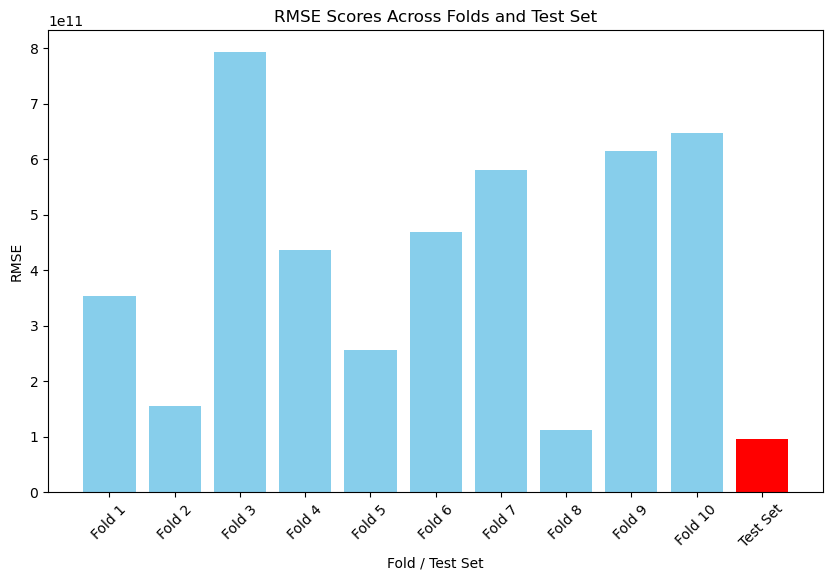

In [39]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set')
plt.show()


### Model 2 : DecisionTreeRegressor 

In [40]:
from sklearn.tree import DecisionTreeRegressor

# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = DecisionTreeRegressor(random_state=2024)

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.39
Cross-Validation R-squared: 0.64
Test RMSE: 0.37
Test R-squared: 0.67


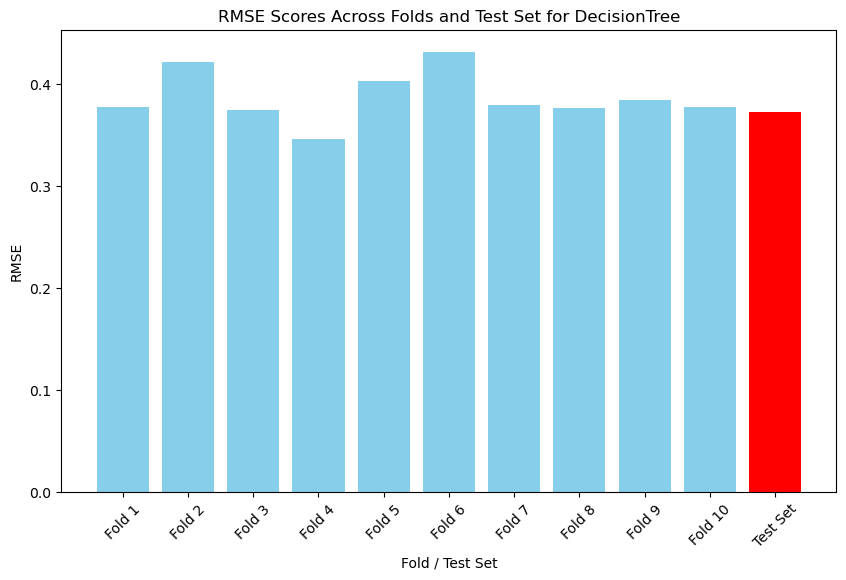

In [41]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for DecisionTree')
plt.show()


### Model 3 : RandomForestRegressor 

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = RandomForestRegressor(random_state=2024)

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.31
Cross-Validation R-squared: 0.77
Test RMSE: 0.32
Test R-squared: 0.76


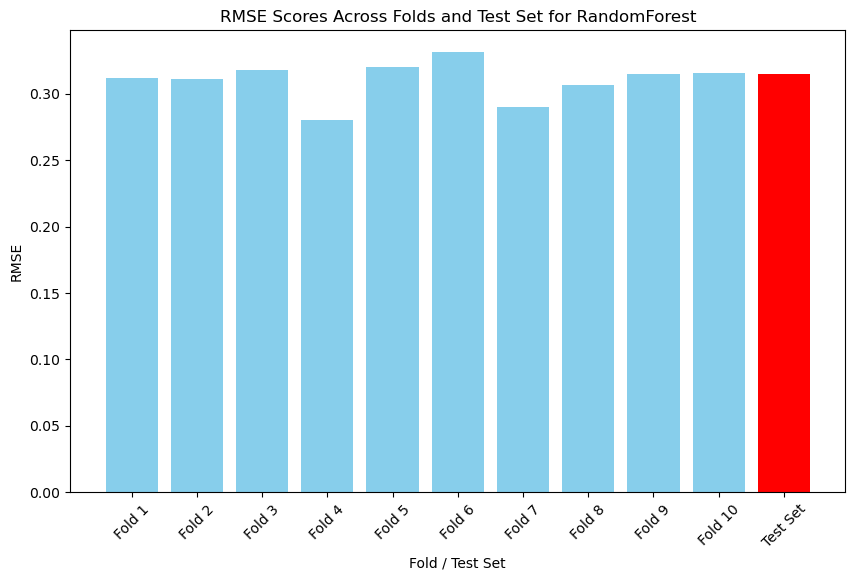

In [43]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for RandomForest')
plt.show()


### Model 4 : Support Vector Regression

In [44]:
from sklearn.svm import SVR

# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = SVR()

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))


Cross-Validation RMSE: 0.41
Cross-Validation R-squared: 0.60
Test RMSE: 0.41
Test R-squared: 0.60


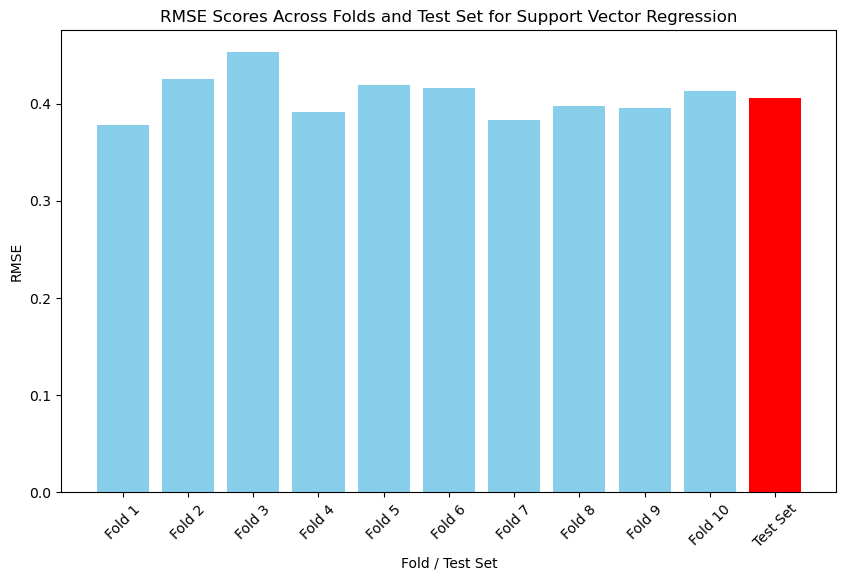

In [45]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for Support Vector Regression')
plt.show()


### Model 5 : XGBoost

In [46]:
import xgboost as xgb

# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Initialize the model
model = xgb.XGBRegressor(random_state=2024)

# Evaluate model performance through cross-validation
rmse_scores = []  # List to store RMSE scores
r2_scores = []    # List to store R-squared scores
for train_index, val_index in k_fold.split(X_train1):
    X_train_fold, X_val_fold = X_train1[train_index], X_train1[val_index]
    y_train_fold, y_val_fold = y_train1[train_index], y_train1[val_index]
    
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))  # Calculate RMSE
    rmse_scores.append(rmse)
    
    r2 = r2_score(y_val_fold, y_pred)  # Calculate R-squared
    r2_scores.append(r2)

# Calculate average RMSE and R-squared through cross-validation
avg_rmse = np.mean(rmse_scores)
avg_r2 = np.mean(r2_scores)
print("Cross-Validation RMSE: {:.2f}".format(avg_rmse))
print("Cross-Validation R-squared: {:.2f}".format(avg_r2))

# Retrain the model using all training data and evaluate performance on the test set
model.fit(X_train1, y_train1)
test_predictions = model.predict(X_test1)
test_rmse = np.sqrt(mean_squared_error(y_test1, test_predictions))
test_r2 = r2_score(y_test1, test_predictions)
print("Test RMSE: {:.2f}".format(test_rmse))
print("Test R-squared: {:.2f}".format(test_r2))



Cross-Validation RMSE: 0.27
Cross-Validation R-squared: 0.82
Test RMSE: 0.28
Test R-squared: 0.81


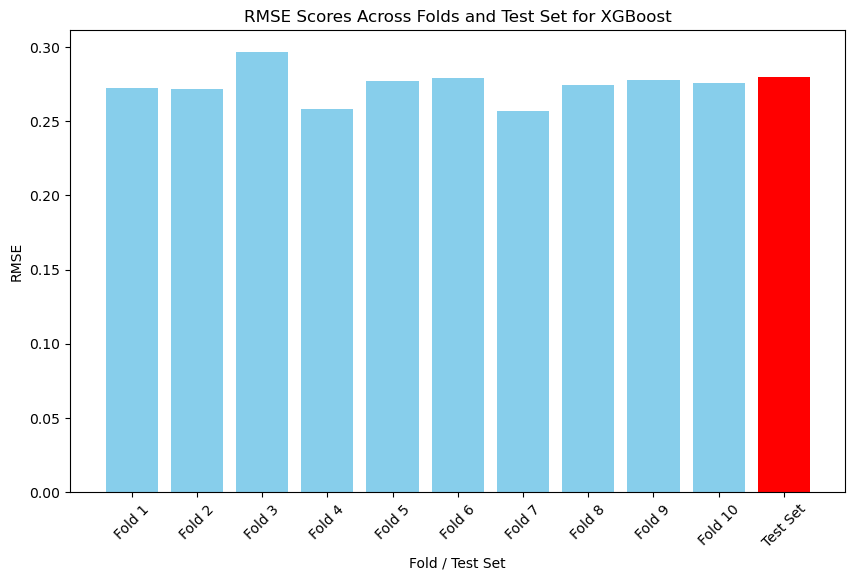

In [47]:
# Concatenate rmse_scores with test_mse
all_rmse = rmse_scores + [test_rmse]

# Create labels for the folds and the test set
fold_labels = [f'Fold {i}' for i in range(1, len(rmse_scores) + 1)]
labels = fold_labels + ['Test Set']

# Plotting RMSE scores
plt.figure(figsize=(10, 6))
colors = ['skyblue'] * len(rmse_scores) + ['red']  # Assign colors to bars
plt.bar(range(1, len(all_rmse) + 1), all_rmse, color=colors)
plt.xticks(range(1, len(all_rmse) + 1), labels, rotation=45)
plt.xlabel('Fold / Test Set')
plt.ylabel('RMSE')
plt.title('RMSE Scores Across Folds and Test Set for XGBoost')
plt.show()


###  Model Comparison

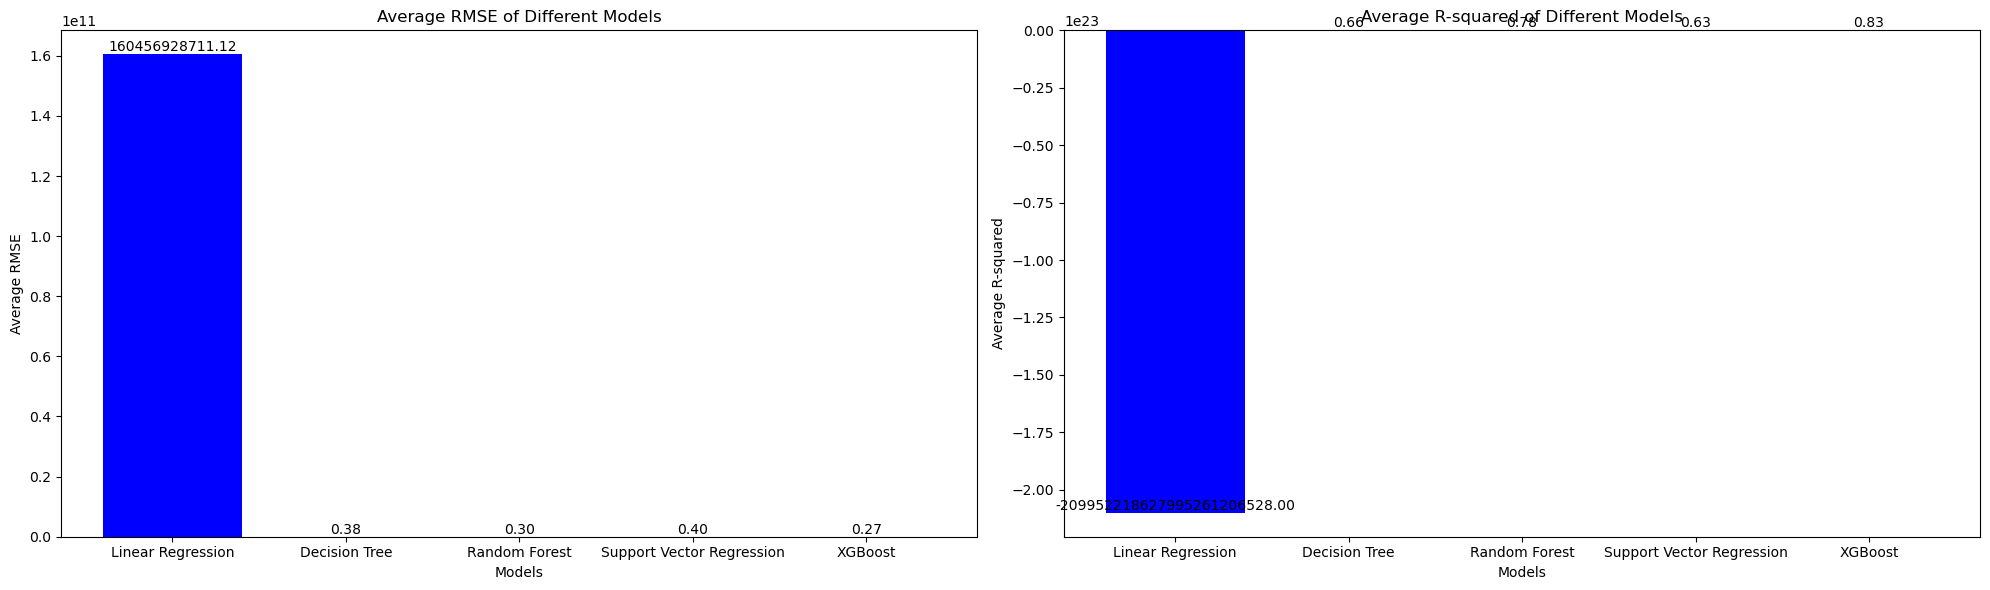

In [48]:

# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Define lists to store evaluation metrics
rmse_scores_lr = []
r2_scores_lr = []

rmse_scores_dt = []
r2_scores_dt = []

rmse_scores_rf = []
r2_scores_rf = []

rmse_scores_svr = []
r2_scores_svr = []

rmse_scores_xgb = []
r2_scores_xgb = []

# Iterate through each fold
for train_index, test_index in k_fold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit and predict using Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_fold, y_train_fold)
    lr_pred = lr_model.predict(X_test_fold)
    rmse_lr = mean_squared_error(y_test_fold, lr_pred, squared=False)
    rmse_scores_lr.append(rmse_lr)
    r2_lr = r2_score(y_test_fold, lr_pred)
    r2_scores_lr.append(r2_lr)

    # Fit and predict using Decision Tree
    dt_model = DecisionTreeRegressor(random_state=2024)
    dt_model.fit(X_train_fold, y_train_fold)
    dt_pred = dt_model.predict(X_test_fold)
    rmse_dt = mean_squared_error(y_test_fold, dt_pred, squared=False)
    rmse_scores_dt.append(rmse_dt)
    r2_dt = r2_score(y_test_fold, dt_pred)
    r2_scores_dt.append(r2_dt)

    # Fit and predict using Random Forest
    rf_model = RandomForestRegressor(random_state=2024)
    rf_model.fit(X_train_fold, y_train_fold)
    rf_pred = rf_model.predict(X_test_fold)
    rmse_rf = mean_squared_error(y_test_fold, rf_pred, squared=False)
    rmse_scores_rf.append(rmse_rf)
    r2_rf = r2_score(y_test_fold, rf_pred)
    r2_scores_rf.append(r2_rf)

    # Fit and predict using Support Vector Regression
    svr_model = SVR()
    svr_model.fit(X_train_fold, y_train_fold)
    svr_pred = svr_model.predict(X_test_fold)
    rmse_svr = mean_squared_error(y_test_fold, svr_pred, squared=False)
    rmse_scores_svr.append(rmse_svr)
    r2_svr = r2_score(y_test_fold, svr_pred)
    r2_scores_svr.append(r2_svr)
    
    # Fit and predict using XGBRegressor
    xgb_model = XGBRegressor(random_state=2024)
    xgb_model.fit(X_train_fold, y_train_fold)
    xgb_pred = xgb_model.predict(X_test_fold)
    rmse_xgb = mean_squared_error(y_test_fold, xgb_pred, squared=False)
    rmse_scores_xgb.append(rmse_xgb)
    r2_xgb = r2_score(y_test_fold, xgb_pred)
    r2_scores_xgb.append(r2_xgb)

# Calculate mean of RMSE and R-squared across all folds
mean_rmse_lr = np.mean(rmse_scores_lr)
mean_rmse_dt = np.mean(rmse_scores_dt)
mean_rmse_rf = np.mean(rmse_scores_rf)
mean_rmse_svr = np.mean(rmse_scores_svr)
mean_rmse_xgb = np.mean(rmse_scores_xgb)

mean_r2_lr = np.mean(r2_scores_lr)
mean_r2_dt = np.mean(r2_scores_dt)
mean_r2_rf = np.mean(r2_scores_rf)
mean_r2_svr = np.mean(r2_scores_svr)
mean_r2_xgb = np.mean(r2_scores_xgb)

# Plotting RMSE
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
labels = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Support Vector Regression', 'XGBoost']
rmse_means = [mean_rmse_lr, mean_rmse_dt, mean_rmse_rf, mean_rmse_svr, mean_rmse_xgb]
plt.bar(labels, rmse_means, color=['blue', 'orange', 'green', 'red', 'purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different Models')
plt.xlabel('Models')
plt.ylabel('Average RMSE')

# Plotting R-squared
plt.subplot(1, 2, 2)
r2_means = [mean_r2_lr, mean_r2_dt, mean_r2_rf, mean_r2_svr, mean_r2_xgb]
plt.bar(labels, r2_means, color=['blue', 'orange', 'green', 'red', 'purple'])

# Adding R-squared values on the bars
for i in range(len(r2_means)):
    plt.text(i, r2_means[i], f'{r2_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average R-squared of Different Models')
plt.xlabel('Models')
plt.ylabel('Average R-squared')

plt.tight_layout()
plt.show()


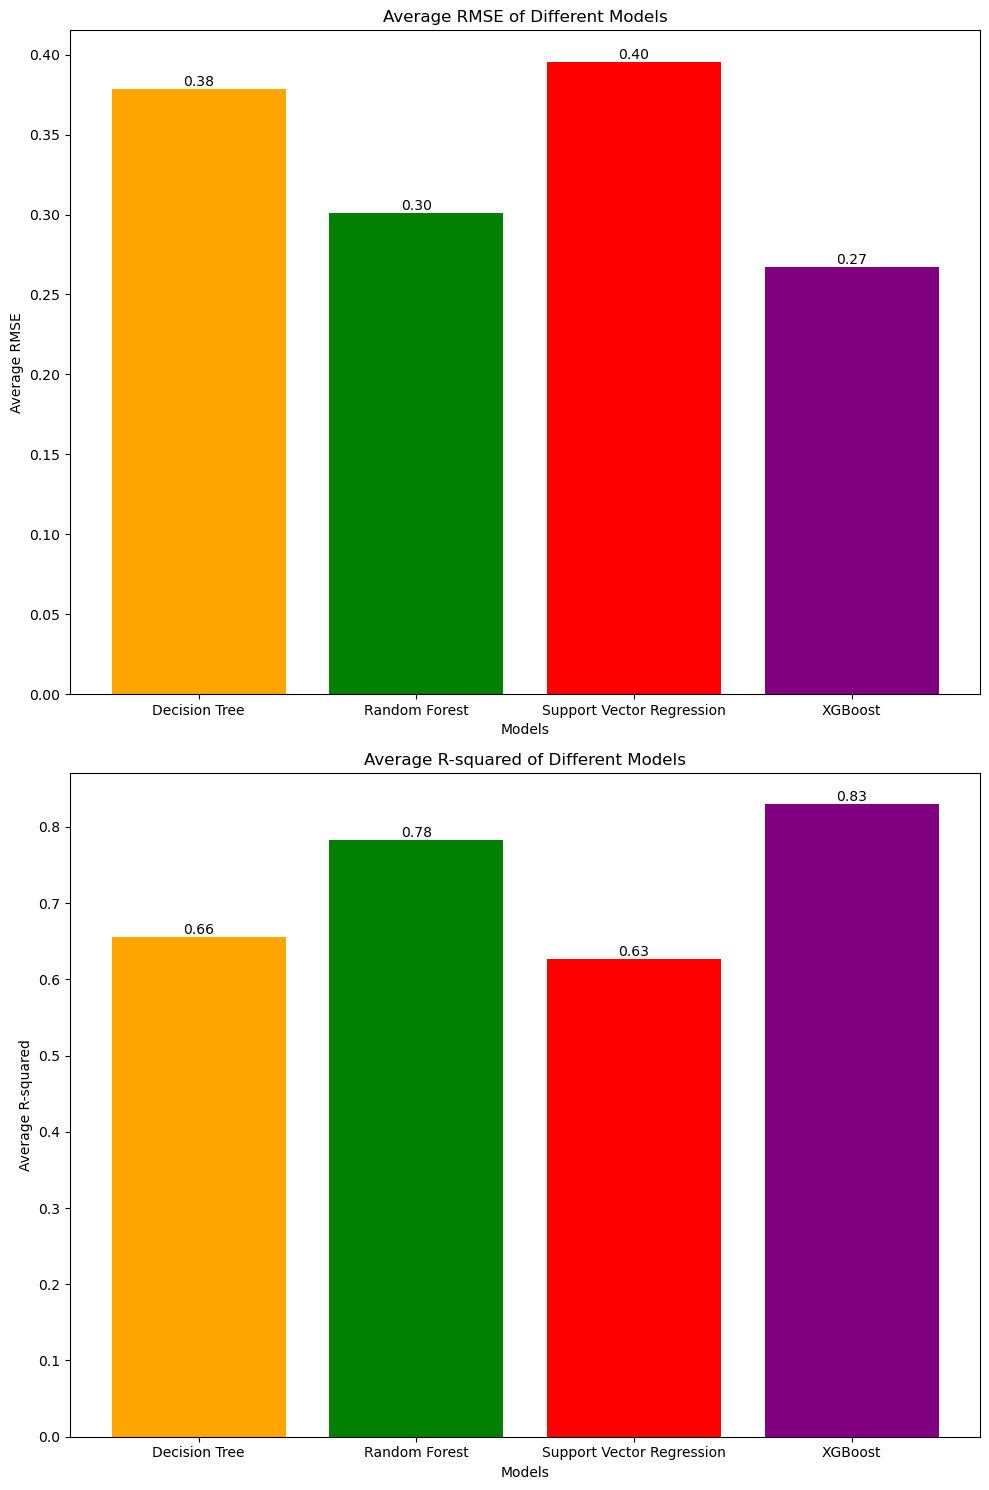

In [49]:
# Plotting RMSE
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
labels = ['Decision Tree', 'Random Forest', 'Support Vector Regression', 'XGBoost']
rmse_means = [mean_rmse_dt, mean_rmse_rf, mean_rmse_svr, mean_rmse_xgb]
plt.bar(labels, rmse_means, color=['orange', 'green', 'red', 'purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different Models')
plt.xlabel('Models')
plt.ylabel('Average RMSE')

# Plotting R-squared
plt.subplot(2, 1, 2)
r2_means = [mean_r2_dt, mean_r2_rf, mean_r2_svr, mean_r2_xgb]
plt.bar(labels, r2_means, color=['orange', 'green', 'red', 'purple'])

# Adding R-squared values on the bars
for i in range(len(r2_means)):
    plt.text(i, r2_means[i], f'{r2_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average R-squared of Different Models')
plt.xlabel('Models')
plt.ylabel('Average R-squared')

plt.tight_layout()
plt.show()



In [73]:
# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Define lists to store evaluation metrics
rmse_scores_xgb_1 = []
rmse_scores_xgb_2 = []
rmse_scores_xgb_3 = []
rmse_scores_xgb_4 = []
rmse_scores_xgb_5 = []

r2_scores_xgb_1 = []
r2_scores_xgb_2 = []
r2_scores_xgb_3 = []
r2_scores_xgb_4 = []
r2_scores_xgb_5 = []

# Iterate through each fold
for train_index, test_index in k_fold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Fit and predict using XGBRegressor
    xgb_model_1 = XGBRegressor()
    xgb_model_1.fit(X_train_fold, y_train_fold)
    xgb_pred_1 = xgb_model_1.predict(X_test_fold)
    rmse_xgb_1 = mean_squared_error(y_test_fold, xgb_pred_1, squared=False)
    rmse_scores_xgb_1.append(rmse_xgb_1)
    r2_xgb_1 = r2_score(y_test_fold, xgb_pred_1)
    r2_scores_xgb_1.append(r2_xgb_1)
    
    # Fit and predict using XGBRegressor with learning_rate = 0.1
    xgb_model_2 = XGBRegressor(learning_rate=0.1)
    xgb_model_2.fit(X_train_fold, y_train_fold)
    xgb_pred_2 = xgb_model_2.predict(X_test_fold)
    rmse_xgb_2 = mean_squared_error(y_test_fold, xgb_pred_2, squared=False)
    rmse_scores_xgb_2.append(rmse_xgb_2)
    r2_xgb_2 = r2_score(y_test_fold, xgb_pred_2)
    r2_scores_xgb_2.append(r2_xgb_2)
    
    # Fit and predict using XGBRegressor with learning_rate = 0.5
    xgb_model_3 = XGBRegressor(learning_rate=0.5)
    xgb_model_3.fit(X_train_fold, y_train_fold)
    xgb_pred_3 = xgb_model_3.predict(X_test_fold)
    rmse_xgb_3 = mean_squared_error(y_test_fold, xgb_pred_3, squared=False)
    rmse_scores_xgb_3.append(rmse_xgb_3)
    r2_xgb_3 = r2_score(y_test_fold, xgb_pred_3)
    r2_scores_xgb_3.append(r2_xgb_3)
    
    # Fit and predict using XGBRegressor with n_estimators = 50
    xgb_model_4 = XGBRegressor(n_estimators=50)
    xgb_model_4.fit(X_train_fold, y_train_fold)
    xgb_pred_4 = xgb_model_4.predict(X_test_fold)
    rmse_xgb_4 = mean_squared_error(y_test_fold, xgb_pred_4, squared=False)
    rmse_scores_xgb_4.append(rmse_xgb_4)
    r2_xgb_4 = r2_score(y_test_fold, xgb_pred_4)
    r2_scores_xgb_4.append(r2_xgb_4)
    
    
    # Fit and predict using XGBRegressor with n_estimators = 500 
    xgb_model_5 = XGBRegressor(n_estimators=500)
    xgb_model_5.fit(X_train_fold, y_train_fold)
    xgb_pred_5 = xgb_model_5.predict(X_test_fold)
    rmse_xgb_5 = mean_squared_error(y_test_fold, xgb_pred_5, squared=False)
    rmse_scores_xgb_5.append(rmse_xgb_5)
    r2_xgb_5 = r2_score(y_test_fold, xgb_pred_5)
    r2_scores_xgb_5.append(r2_xgb_5)
    

# Calculate mean of RMSE and R-squared across all folds
mean_rmse_xgb_1 = np.mean(rmse_scores_xgb_1)
mean_rmse_xgb_2 = np.mean(rmse_scores_xgb_2)
mean_rmse_xgb_3 = np.mean(rmse_scores_xgb_3)
mean_rmse_xgb_4 = np.mean(rmse_scores_xgb_4)
mean_rmse_xgb_5 = np.mean(rmse_scores_xgb_5)

mean_r2_xgb_1 = np.mean(r2_scores_xgb_1)
mean_r2_xgb_2 = np.mean(r2_scores_xgb_2)
mean_r2_xgb_3 = np.mean(r2_scores_xgb_3)
mean_r2_xgb_4 = np.mean(r2_scores_xgb_4)
mean_r2_xgb_5 = np.mean(r2_scores_xgb_5)


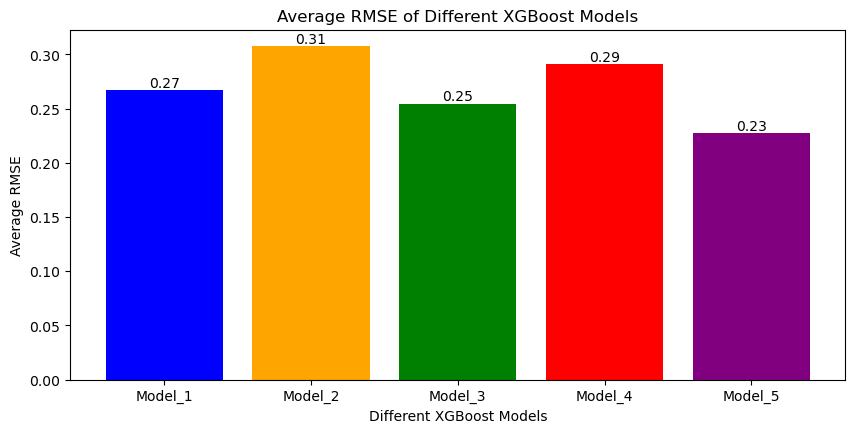

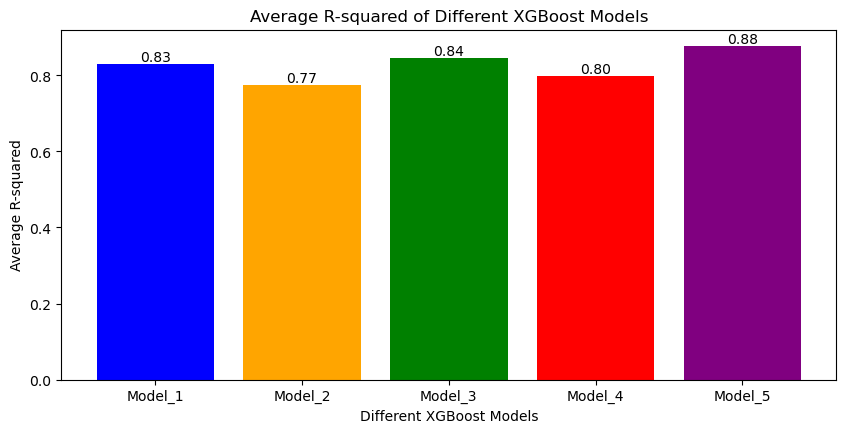

In [91]:

# Plotting RMSE
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
labels = ['Model_1', 'Model_2', 'Model_3','Model_4','Model_5']
rmse_means = [mean_rmse_xgb_1, mean_rmse_xgb_2, mean_rmse_xgb_3, mean_rmse_xgb_4, mean_rmse_xgb_5]
plt.bar(labels, rmse_means, color=['blue', 'orange', 'green', 'red','purple'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of Different XGBoost Models')
plt.xlabel('Different XGBoost Models')
plt.ylabel('Average RMSE')
plt.show()

# Plotting R-squared
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
r2_means = [mean_r2_xgb_1, mean_r2_xgb_2, mean_r2_xgb_3, mean_r2_xgb_4,mean_r2_xgb_5]
plt.bar(labels, r2_means, color=['blue', 'orange', 'green', 'red','purple'])

# Adding R-squared values on the bars
for i in range(len(r2_means)):
    plt.text(i, r2_means[i], f'{r2_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average R-squared of Different XGBoost Models')
plt.xlabel('Different XGBoost Models')
plt.ylabel('Average R-squared')
plt.show()

In [80]:
# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

# Convert X_train1 and y_train1 to NumPy arrays if they are not already
X_train1 = np.array(X_train1)
y_train1 = np.array(y_train1)

# Define lists to store evaluation metrics
rmse_scores_xgb_6 = []
r2_scores_xgb_6 = []


# Iterate through each fold
for train_index, test_index in k_fold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    
    # Fit and predict using XGBRegressor with n_estimators = 500 
    xgb_model_6 = XGBRegressor(n_estimators=500, learning_rate=0.5)
    xgb_model_6.fit(X_train_fold, y_train_fold)
    xgb_pred_6 = xgb_model_6.predict(X_test_fold)
    rmse_xgb_6 = mean_squared_error(y_test_fold, xgb_pred_6, squared=False)
    rmse_scores_xgb_6.append(rmse_xgb_6)
    r2_xgb_6 = r2_score(y_test_fold, xgb_pred_6)
    r2_scores_xgb_6.append(r2_xgb_6)
    

# Calculate mean of RMSE across all folds
mean_rmse_xgb_6 = np.mean(rmse_scores_xgb_6)
mean_r2_xgb_6 = np.mean(r2_scores_xgb_6)


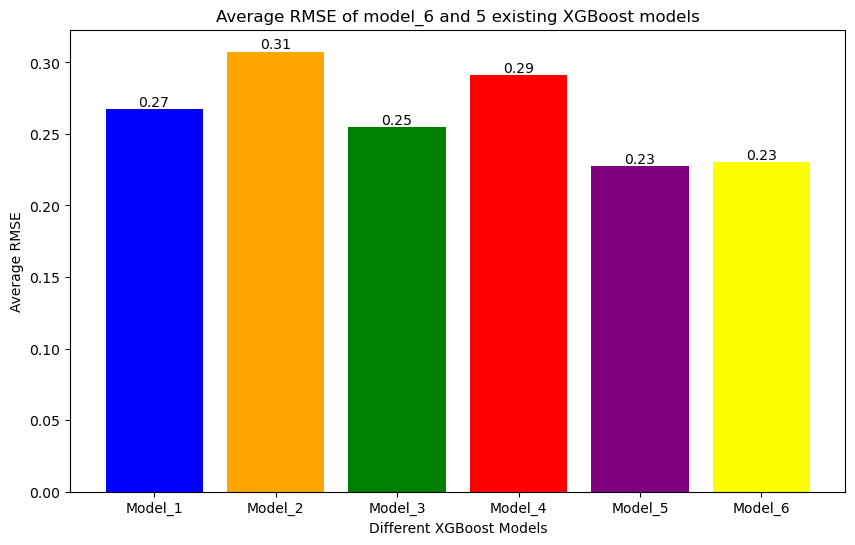

In [88]:
# Plotting
labels = ['Model_1', 'Model_2', 'Model_3','Model_4','Model_5','Model_6' ]
rmse_means = [mean_rmse_xgb_1, mean_rmse_xgb_2, mean_rmse_xgb_3, mean_rmse_xgb_4, mean_rmse_xgb_5,mean_rmse_xgb_6]

plt.figure(figsize=(10, 6))
plt.bar(labels, rmse_means, color=['blue', 'orange', 'green', 'red','purple','yellow'])

# Adding RMSE values on the bars
for i in range(len(rmse_means)):
    plt.text(i, rmse_means[i], f'{rmse_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average RMSE of model_6 and 5 existing XGBoost models')
plt.xlabel('Different XGBoost Models')
plt.ylabel('Average RMSE')
plt.show()

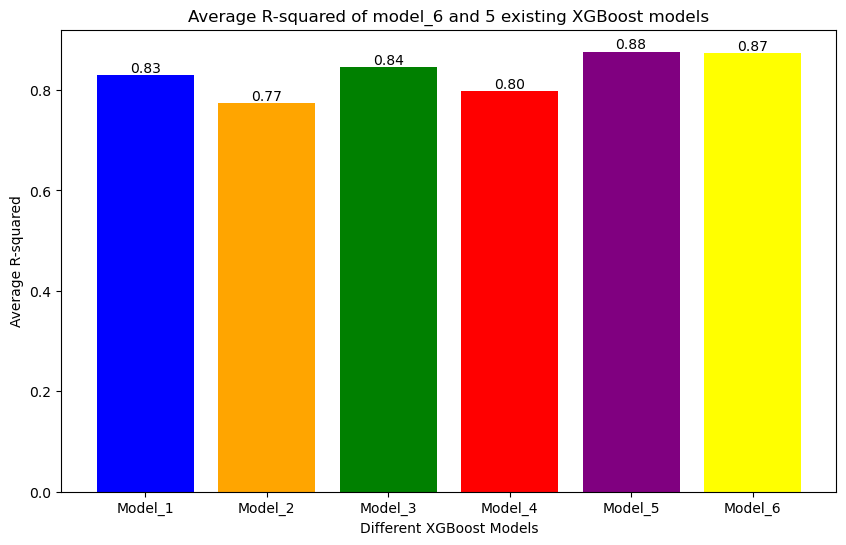

In [90]:
# Plotting
labels = ['Model_1', 'Model_2', 'Model_3','Model_4','Model_5','Model_6' ]
r2_means = [mean_r2_xgb_1, mean_r2_xgb_2, mean_r2_xgb_3, mean_r2_xgb_4,mean_r2_xgb_5,mean_r2_xgb_6 ]

plt.figure(figsize=(10, 6))
plt.bar(labels, r2_means, color=['blue', 'orange', 'green', 'red','purple','yellow'])

# Adding RMSE values on the bars
for i in range(len(r2_means)):
    plt.text(i, r2_means[i], f'{r2_means[i]:.2f}', ha='center', va='bottom')
    
plt.title('Average R-squared of model_6 and 5 existing XGBoost models')
plt.xlabel('Different XGBoost Models')
plt.ylabel('Average R-squared')
plt.show()

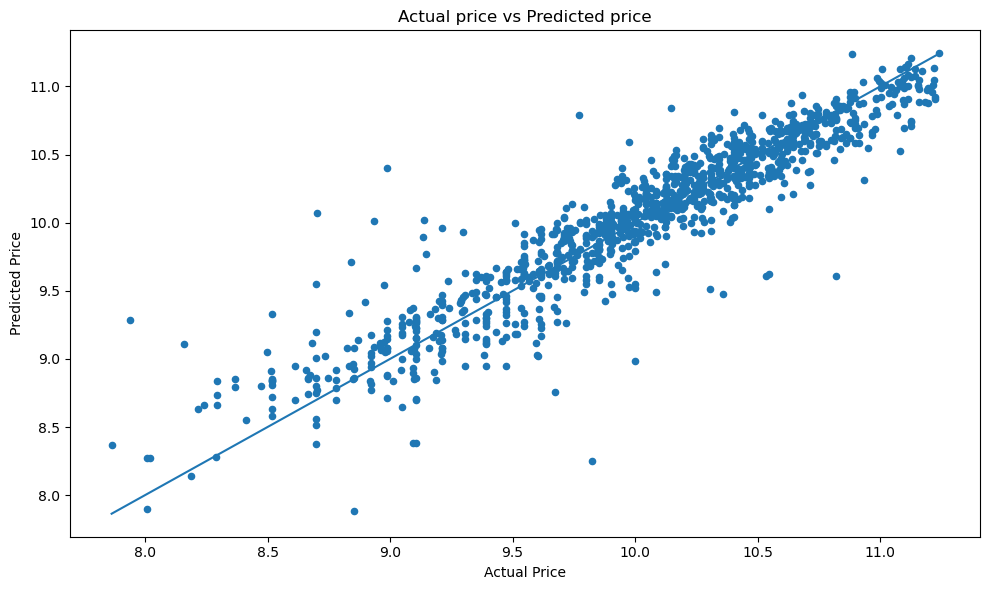

In [43]:
# Fix random seed for reproducibility
np.random.seed(2024)

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

xgb_model_5 = XGBRegressor(n_estimators=500)

# Train model
xgb_model = xgb_model_5.fit(X_train1, y_train1, verbose=False)

# Predict test data set
y_pred = xgb_model.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Actual price vs Predicted price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

### Predict Used_Car Values

In [94]:
brand = 'honda'
model = 'odyssey'
year = int(2016)
mileage = int(75000)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
target = pd.DataFrame(columns=[X_train1.columns])

In [95]:
brand_index = 0
for col in X_train1.columns:
    if col == 'Brand' + "_" + brand:
        break;
    brand_index += 1
brand_index

19

In [96]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train1.columns:
    if col == 'Model' + "_" + model:
        break;
    model_index += 1
    
model_index

637

In [97]:
# Array of zeros
target_list = np.zeros_like(X_train1.iloc[0])

In [98]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

In [99]:
# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = mileage

In [100]:
# Convert all elements in target_list with 0 being False and 1 being True
transformed_values = [True if x == 1 else False for x in target_list[2:]]
target_list = [target_list[0], target_list[1]] + transformed_values

In [101]:
# Insert data into target data frame
for i in range(1):
    target.loc[i] = target_list

In [102]:
numerical_features = ['Year', 'Mileage']

In [103]:
target[numerical_features]

,Year,Mileage
0,2016,75000


In [104]:
# Convert the values in the Year and Mileage columns to float form and apply the log1p function
normalize_target = target[numerical_features].astype(float).apply(np.log1p)
print(normalize_target)

       Year    Mileage
0  7.609367  11.225257


In [105]:
# After deleting the Year and Mileage columns, combine them with the normalize_target dataframe to create target_goal.
target.drop(['Year', 'Mileage'], axis=1, level=0, inplace=True)
target_goal = normalize_target.join(target)
target_goal

,Year,Mileage,Brand_acura,Brand_alfa romeo,Brand_alfa_romeo,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,...,Model_yaris,Model_yaris_ia,Model_yaris_sedan,Model_yukon,Model_yukon xl,Model_yukon_xl,Model_z,Model_z3,Model_z4,Model_zdx
0,7.609367,11.225257,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [106]:
# Predicted logged price
price_log = xgb_model_5.predict(target_goal)

In [107]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print(f"Brand : {brand.upper()}")
print(f"Model : {model.upper()}")
print(f"Year  : {year}")
print(f"Mileage  : {mileage}")
print(f"Estimated Price : ${int(price)}")

Brand : HONDA
Model : ODYSSEY
Year  : 2016
Mileage  : 75000
Estimated Price : $18321


### Compare same model with different years

In [108]:
# Find the average of the same model for each year
actual_car_info = train[["Brand", "Model", "Year", "Mileage", "Price"]]

same_model = actual_car_info[actual_car_info["Model"]== model] 
same_model_at_dataset = same_model[["Brand","Model","Year","Mileage","Price"]]
same_model_at_dataset_by_year = same_model_at_dataset.groupby("Year").agg({'Price':np.mean}).astype('int')
same_model_at_dataset_by_year = same_model_at_dataset_by_year.reset_index()
same_model_at_dataset_by_year

,Year,Price
0,2018,23931
1,2019,27993
2,2023,46998


In [109]:
same_model_at_dataset

,Brand,Model,Year,Mileage,Price
552,honda,odyssey,2019,25891,28991
1672,honda,odyssey,2019,50425,26995
1968,honda,odyssey,2023,1408,46998
2856,honda,odyssey,2018,66368,23931


In [44]:
pickle.dump(xgb_model_5, open("./Flask/pickle/model.pkl", "wb"))
pickle.dump(X_train1.columns, open("./Flask/pickle/column.pkl", "wb"))

actual_car_info = train[["Brand", "Model", "Year", "Mileage", "Price"]]
pickle.dump(actual_car_info, open("./Flask/pickle/actual_car_info.pkl", "wb"))

target_list = np.zeros_like(X_train1.iloc[0])
pickle.dump(target_list, open("./Flask/pickle/target_list.pkl", "wb"))